In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [2]:
from transformers import (
    GPT2Config,
    GPT2Tokenizer,
    GPT2LMHeadModel,
)

/home/cgagne/cvar_generation/conda_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
modelname = '../models/pretrained/gpt2-large/'
config = GPT2Config.from_pretrained(modelname)
tokenizer = GPT2Tokenizer.from_pretrained(modelname)

In [4]:
import sys
sys.path.append('../')
from rl_learner import TD_Learner
import torch
import pickle
device = 'cpu'
import sys
sys.path.append('../')

from cvar_helpers import calc_cvar_from_samples
from train_rl_batch_sentence_chains import average_states_by_period

## Regular (Non-Whatif's)

### Loading Training Data 

In [5]:
file = '../data/results/sentence_chains_I_5/generations_using.txt'
f = open(file, "r")
sentences = f.readlines()
sentences = [s.replace('\n','') for s in sentences]
composite_rewards =[s.split('r_all=')[1] for s in sentences]
sentences_wo_rall = [s.split('r_all=')[0] for s in sentences]
state_rewards =  [np.array(s.split('r=')[-1].split(',')).astype('float') for s in sentences_wo_rall]


In [6]:
# removing some bad examples #
state_rewards2 = []
sentences2 = []
composite_rewards2 = []
for r,s,rc in zip(state_rewards, sentences, composite_rewards):
    if len(r)!=3:
        pass
    else:
        state_rewards2.append(r)
        sentences2.append(s)
        composite_rewards2.append(rc)
sentences = sentences2
state_rewards = np.array(state_rewards2)
composite_rewards = np.array(composite_rewards2).astype('float')

# choose rewards 
summed_rewards = state_rewards.sum(axis=1)
final_rewards = state_rewards[:,-1]


assert len(sentences) == len(final_rewards)

In [7]:
np.array(state_rewards)

array([[ 0.396, -0.226,  0.012],
       [-0.018,  0.162,  0.988],
       [ 0.132, -0.83 , -0.15 ],
       ...,
       [ 0.672,  0.752,  0.875],
       [ 0.16 , -0.053,  0.002],
       [-0.277,  0.972,  0.988]])

In [8]:
summed_rewards

array([ 0.182,  1.132, -0.848, ...,  2.299,  0.109,  1.683])

In [9]:
final_rewards

array([ 0.012,  0.988, -0.15 , ...,  0.875,  0.002,  0.988])

In [10]:
composite_rewards

array([ 0.857,  0.954, -0.698, ...,  0.779,  0.479,  0.991])

In [11]:
len(sentences)
len(final_rewards)

12534

### Plotting the distributions

Text(0.5, 1.0, 'composite reward')

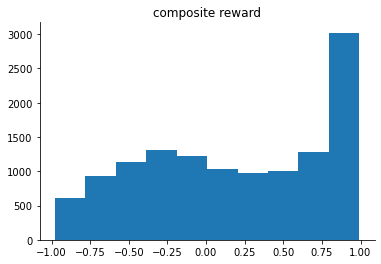

In [12]:
plt.hist(composite_rewards)
sns.despine()
plt.title('composite reward')

Text(0.5, 1.0, 'final reward')

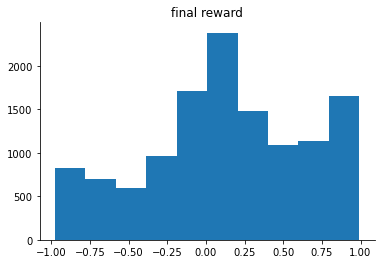

In [13]:
plt.hist(final_rewards)
sns.despine()
plt.title('final reward')

Text(0.5, 1.0, 'summed reward')

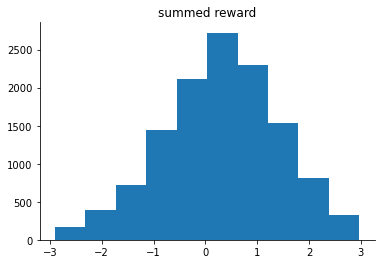

In [14]:
plt.hist(summed_rewards)
sns.despine()
plt.title('summed reward')

### Plotting the distributions (by stems)

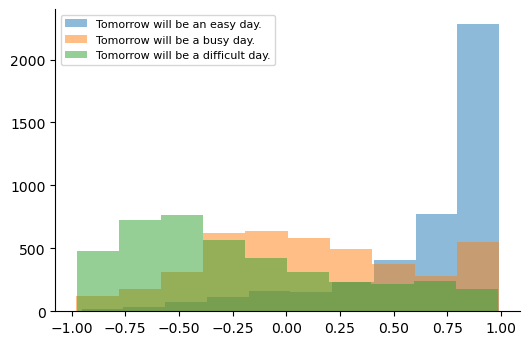

In [15]:
stems = ["Tomorrow will be an easy day.",
         "Tomorrow will be a busy day.",
         "Tomorrow will be a difficult day."]

plt.figure(dpi=100)
for stem in stems:
    sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')
    plt.hist(composite_rewards[sel], label=stem, alpha=0.5)
    plt.legend(fontsize=8)
sns.despine()

In [16]:
stem in sentences[0]

False

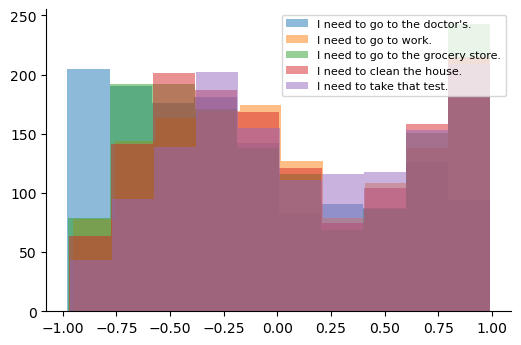

In [17]:
stems = ["I need to go to the doctor's.", 'I need to go to work.', 
         'I need to go to the grocery store.', 'I need to clean the house.',  'I need to take that test.',]

plt.figure(dpi=100)
for stem in stems:
    sel = np.array([True if stem in s else False for s in sentences ]).astype('bool')
    plt.hist(composite_rewards[sel], label=stem, alpha=0.5)
    plt.legend(fontsize=8)
sns.despine()

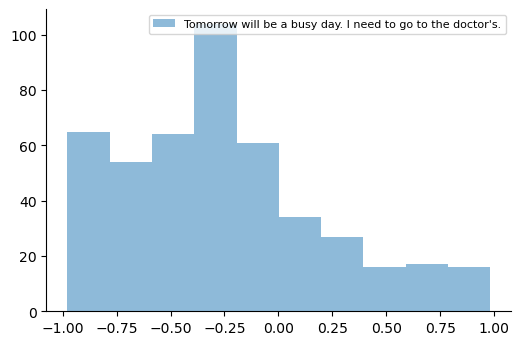

In [105]:
stems = ["Tomorrow will be a busy day. I need to go to the doctor's.", ]

plt.figure(dpi=100)
for stem in stems:
    sel = np.array([True if stem in s else False for s in sentences ]).astype('bool')
    plt.hist(composite_rewards[sel], label=stem, alpha=0.5)
    plt.legend(fontsize=8)
sns.despine()

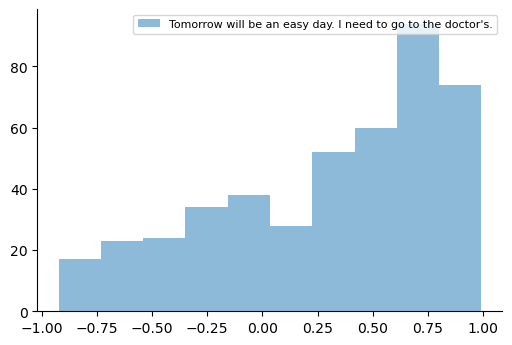

In [107]:
stems = ["Tomorrow will be an easy day. I need to go to the doctor's.", ]

plt.figure(dpi=100)
for stem in stems:
    sel = np.array([True if stem in s else False for s in sentences ]).astype('bool')
    plt.hist(composite_rewards[sel], label=stem, alpha=0.5)
    plt.legend(fontsize=8)
sns.despine()

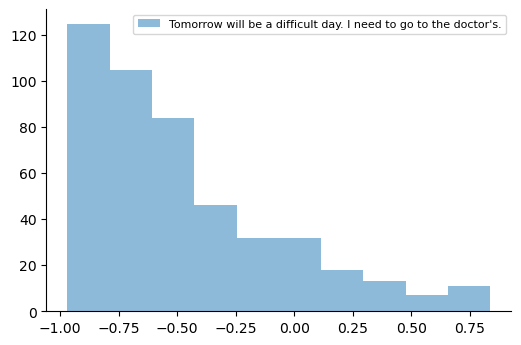

In [111]:
stems = ["Tomorrow will be a difficult day. I need to go to the doctor's.", ]

plt.figure(dpi=100)
for stem in stems:
    sel = np.array([True if stem in s else False for s in sentences ]).astype('bool')
    plt.hist(composite_rewards[sel], label=stem, alpha=0.5)
    plt.legend(fontsize=8)
sns.despine()

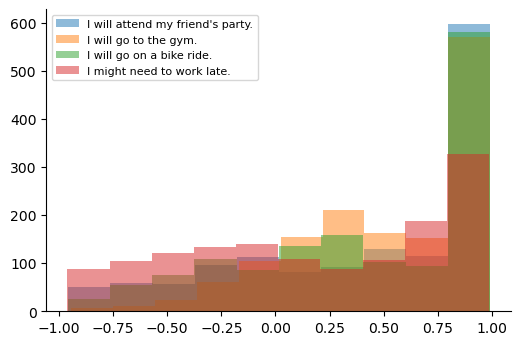

In [18]:
stems = ["I will attend my friend's party.", "I will go to the gym.", "I will go on a bike ride.", "I might need to work late." ]

plt.figure(dpi=100)
for stem in stems:
    sel = np.array([True if stem in s else False for s in sentences ]).astype('bool')
    plt.hist(composite_rewards[sel], label=stem, alpha=0.5)
    plt.legend(fontsize=8)
sns.despine()

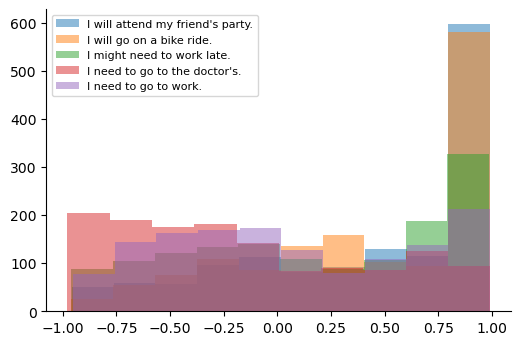

In [19]:
stems = ["I will attend my friend's party.", "I will go on a bike ride.", "I might need to work late.", "I need to go to the doctor's.", 'I need to go to work.',  ]

plt.figure(dpi=100)
for stem in stems:
    sel = np.array([True if stem in s else False for s in sentences ]).astype('bool')
    plt.hist(composite_rewards[sel], label=stem, alpha=0.5)
    plt.legend(fontsize=8)
sns.despine()

### Print some Negative Examples

#### Final rewards

In [20]:
sort_idx = np.argsort(final_rewards)
for s in np.array(sentences)[sort_idx][0:20]:
    print(s)
    print()

Tomorrow will be a difficult day. I will go on a bike ride. I am in a strange place right now, I am in a depression. I have no life. I am tired of looking after my children and it's not fair to them. p=0.084,0.085,0.101 r=-0.794,-0.917,-0.977 r_all=-0.96

Tomorrow will be a difficult day. I need to go to the grocery store. You see, my daughter is a big girl, and she is just as small as I am. I do not like her at all. I hate the way she walks, the way she talks, the way she acts. p=0.083,0.079,0.072 r=0.33,-0.973,-0.977 r_all=-0.976

Tomorrow will be an easy day. I need to go to the grocery store. I have a lot of things to do. I don't want to be here too long. The world is a bad place. p=0.082,0.081,0.088 r=-0.067,-0.825,-0.975 r_all=-0.479

Tomorrow will be a busy day. I need to go to the doctor's. I need to see my doctor. I need to get a new prescription for this stuff. This stuff is giving me this horrible feeling in my stomach. p=0.138,0.117,0.1 r=-0.642,-0.56,-0.972 r_all=-0.95

To

#### Summed Rewards

In [21]:
sort_idx = np.argsort(summed_rewards)
for s in np.array(sentences)[sort_idx][0:20]:
    print(s)
    print()

Tomorrow will be an easy day. I need to go to work. I don't like this, I don't like the weather. I don't like the news. I don't like being here. p=0.082,0.103,0.107 r=-0.976,-0.961,-0.967 r_all=-0.953

Tomorrow will be a busy day. I need to go to the doctor's. I've been vomiting for the past few days, and it's getting worse. I can't stand it anymore. I want to die. p=0.076,0.091,0.083 r=-0.981,-0.952,-0.949 r_all=-0.978

Tomorrow will be a difficult day. I need to clean the house. I'm not happy with my relationship with my dad. I'm not happy with my marriage. I'm not happy with my situation. p=0.079,0.093,0.285 r=-0.964,-0.956,-0.96 r_all=-0.961

Tomorrow will be a difficult day. I need to clean the house. And that is the worst part of this whole thing. I'm so tired and frustrated. I just don't want to go to sleep anymore. p=0.081,0.095,0.069 r=-0.97,-0.955,-0.95 r_all=-0.971

Tomorrow will be a difficult day. I need to take that test. I will say it is the worst moment in my life. This

#### Composite Rewards

In [22]:
sort_idx = np.argsort(composite_rewards)
for s in np.array(sentences)[sort_idx][0:20]:
    print(s)
    print()

Tomorrow will be a busy day. I need to go to the doctor's. I've been vomiting for the past few days, and it's getting worse. I can't stand it anymore. I want to die. p=0.076,0.091,0.083 r=-0.981,-0.952,-0.949 r_all=-0.978

Tomorrow will be a difficult day. I need to go to the grocery store. You see, my daughter is a big girl, and she is just as small as I am. I do not like her at all. I hate the way she walks, the way she talks, the way she acts. p=0.083,0.079,0.072 r=0.33,-0.973,-0.977 r_all=-0.976

Tomorrow will be a difficult day. I need to clean the house. And that is the worst part of this whole thing. I'm so tired and frustrated. I just don't want to go to sleep anymore. p=0.081,0.095,0.069 r=-0.97,-0.955,-0.95 r_all=-0.971

Tomorrow will be a difficult day. I need to go to the grocery store. I will not be able to talk to my kids. I will be so ashamed. I will be so depressed. p=0.091,0.077,0.075 r=-0.946,-0.945,-0.951 r_all=-0.969

Tomorrow will be a difficult day. I need to go t

### Print some Positive Examples

#### Final rewards

In [23]:
sort_idx = np.argsort(final_rewards)
for s in np.array(sentences)[sort_idx][-20:]:
    print(s)
    print()

Tomorrow will be an easy day. I might need to work late. Maybe I'll come back for a little while. But it's a good day to be back here. I love this place, and it's a good place to work. p=0.087,0.108,0.072 r=0.383,0.972,0.99 r_all=0.985

Tomorrow will be a busy day. I might need to work late. So please don't expect anything soon. But I will do my best to give you the best news you could ever imagine. I'm excited about this opportunity. p=0.086,0.079,0.099 r=-0.48,0.956,0.99 r_all=0.954

Tomorrow will be an easy day. I need to go to the grocery store. I have a lot of homework to do today. And I want to go to the gym today because I want to look good for tomorrow. I think that this is going to be a great day. p=0.088,0.073,0.077 r=-0.596,0.942,0.99 r_all=0.979

Tomorrow will be a busy day. I will go to the gym. I will go to the office. I will see my brother. I will be excited about the day. p=0.066,0.092,0.093 r=0.011,0.139,0.991 r_all=0.986

Tomorrow will be an easy day. I will attend my

#### Summed Rewards

In [24]:
sort_idx = np.argsort(summed_rewards)
for s in np.array(sentences)[sort_idx][-20:]:
    print(s)
    print()

Tomorrow will be a busy day. I will attend my friend's party. (laughs)  I'm so glad I can do it. My friend is so cute. (laughs) I'm glad I can meet her. p=0.079,0.107,0.079 r=0.976,0.986,0.963 r_all=0.99

Tomorrow will be an easy day. I will attend my friend's party. My first meeting with a new girl has been perfect. I am very happy. I will meet her in the morning and we will have fun. p=0.067,0.075,0.076 r=0.984,0.985,0.956 r_all=0.992

Tomorrow will be a busy day. I will attend my friend's party. I hope everyone has a good time. Thank you for all of your support and thoughts. I hope to be able to see you all at the game tomorrow. p=0.079,0.079,0.12 r=0.975,0.975,0.976 r_all=0.986

Tomorrow will be an easy day. I might need to work late. But I think I'm going to have fun this afternoon. I'll be having a good time. Don't forget, we've got a great day ahead of us. p=0.075,0.09,0.089 r=0.974,0.966,0.987 r_all=0.987

Tomorrow will be a difficult day. I need to take that test. If I'm still

#### Composite Rewards

In [25]:
sort_idx = np.argsort(composite_rewards)
for s in np.array(sentences)[sort_idx][-20:]:
    print(s)
    print()

Tomorrow will be an easy day. I will attend my friend's party. The party is held on the balcony. The house is beautiful, so I will enjoy it. Thank you for your consideration. p=0.086,0.069,0.068 r=0.025,0.988,0.934 r_all=0.991

Tomorrow will be an easy day. I will attend my friend's party. It is going to be a great one. I will have a good time, and we will get back together. I'm sure you all will be looking forward to it as well. p=0.084,0.103,0.072 r=0.98,0.942,0.962 r_all=0.991

Tomorrow will be an easy day. I will attend my friend's party. It's a great party. I want to be there with my best friend. I'll bring my best friend. p=0.098,0.067,0.126 r=0.976,0.897,0.759 r_all=0.991

Tomorrow will be an easy day. I need to go to the grocery store. I can't wait to see my baby girl. I can't wait to see her smile. She's going to be a big sister to me. p=0.081,0.068,0.083 r=0.989,0.985,0.886 r_all=0.991

Tomorrow will be a busy day. I will attend my friend's party. I have never been so excited

### Examing RL Models

In [49]:
def load_rl_model(epoch=48, hidden_dim =100, n_quantiles = 10, extra = '_composite_rewards',
                  folder = 'sentence_chains_I_4',huber=0.1):

    filename='../data/results/'+folder+'/'
    filename+=f'quantile_learner_{hidden_dim}_{huber}{extra}/log_quantile_learner_epoch{epoch}.pkl'

    Z_network = TD_Learner(config.n_embd, n_quantiles, hidden_dim=hidden_dim)
    Z_network.load_state_dict(torch.load(filename.replace('log_',''),map_location=torch.device('cpu')))

    log = pickle.load(open(filename,'rb'))
    loss = np.array(log['loss'])
    epoch = np.array(log['epoch'])
    
    taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
    
    out = {'Z_network': Z_network,
             'loss': loss,
           'taus' : taus,
          'log':log,
          'epoch':epoch}
    return(out)

In [50]:
def plot_examples(examples, sentences, rewards, tokenizer, model, Z_network, taus):
    
    for example in examples:
    
        plt.figure(figsize=(6,3), dpi=100)
        
        inputs = tokenizer(example, return_tensors='pt').to(device)
        
        with torch.no_grad():
            input_ids = inputs['input_ids']
            mask = inputs['attention_mask']
            output = model(input_ids=input_ids,
                           attention_mask=mask,
                           output_hidden_states=True)
            states = output['hidden_states'][-1]
            states, _ = average_states_by_period(states, mask.unsqueeze(-1), input_ids, device,
                                                n_periods=example.count('.'), period_tok_id=13, pad_tok_id=50256)

            
            theta_hats = Z_network(states).detach().cpu().numpy().round(2)
            theta_hats_last = theta_hats[:,-1,:].squeeze()

            for theta in theta_hats_last:
                plt.axvline(x=theta, linestyle='--', linewidth=0.5)

            sel = np.array([example in s for s in sentences]).astype('bool')
            if np.sum(sel)>0:
                thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus]
                for theta in thetas:
                    plt.axvline(x=theta, ymax=0.5, linestyle='--', linewidth=0.5, color='k')

            plt.xlim([-1.5,1.5])
            plt.axhline(y=0., color='k')
            sns.despine()
            plt.title(example)

#### Load GPT2

In [28]:
model = GPT2LMHeadModel.from_pretrained(modelname)
device='cpu'

#### 100 Hidden Units (20 Epochs)

In [51]:
out = load_rl_model(epoch=19, hidden_dim =100, n_quantiles = 10, extra = '_composite_rewards_slow_lr',
                          folder = 'sentence_chains_I_5',huber=0.1)

In [52]:
v5_stems_1 =["Tomorrow will be an easy day.",
           "Tomorrow will be a busy day.",
           "Tomorrow will be a difficult day."]
v5_stems_2 = ["I need to go to the doctor's.", 'I need to go to work.', 
         'I need to go to the grocery store.', 'I need to clean the house.',  'I need to take that test.']

v5_stems = []
for v5_1 in v5_stems_1:
    for v5_2 in v5_stems_2:
        v5_stems.append(v5_1+' '+v5_2)

In [53]:
v5_stems[0:2]

["Tomorrow will be an easy day. I need to go to the doctor's.",
 'Tomorrow will be an easy day. I need to go to work.']

##### Tracked Sentences

In [54]:
tracked_sentences = [key for key in out['log'].keys() if key not in ['loss','epoch']]

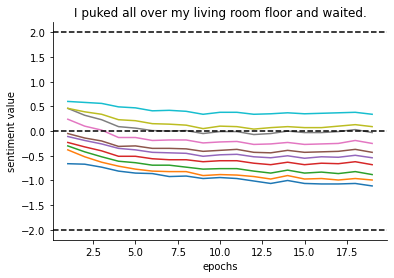

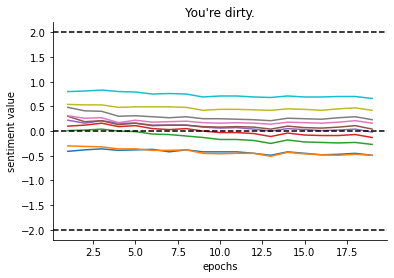

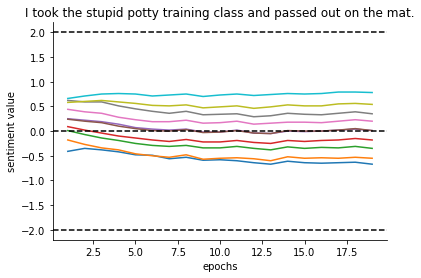

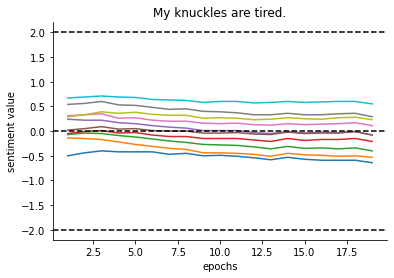

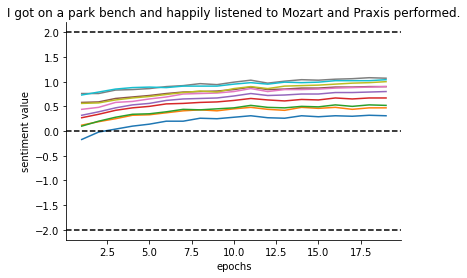

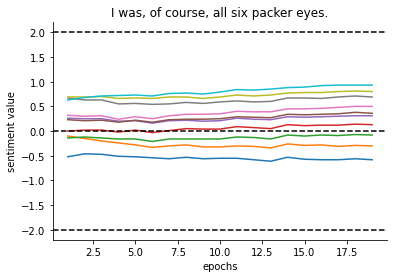

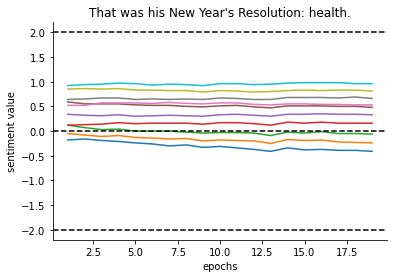

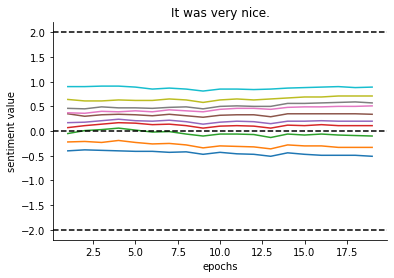

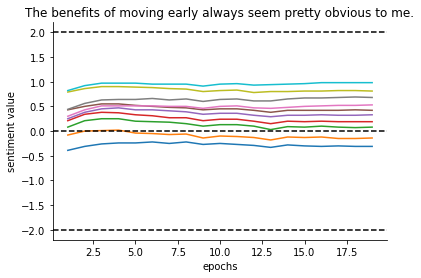

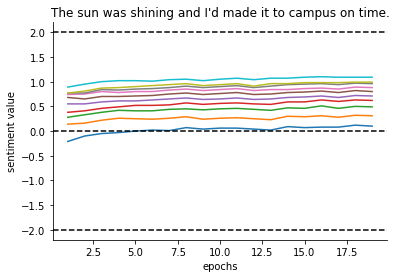

In [55]:
for sent in tracked_sentences:
    plt.figure()
    plt.plot(out['epoch'], np.array(out['log'][sent]))
    sns.despine()
    plt.axhline(y=-2, color='k', linestyle='--')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.axhline(y=2, color='k', linestyle='--')
    plt.ylabel('sentiment value')
    plt.xlabel('epochs')
    plt.title(sent)

##### Stems (part 1)

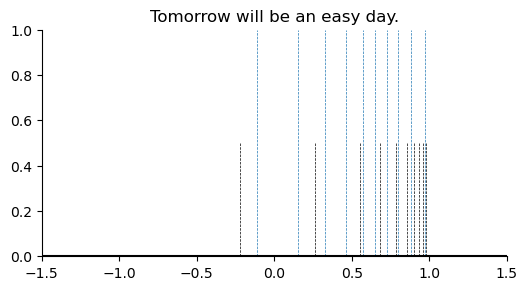

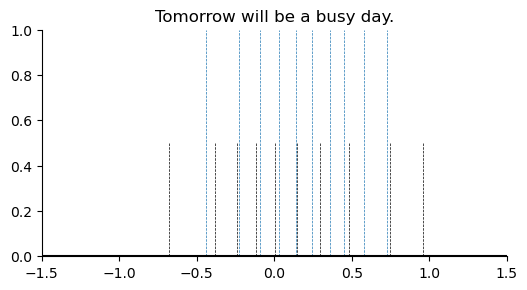

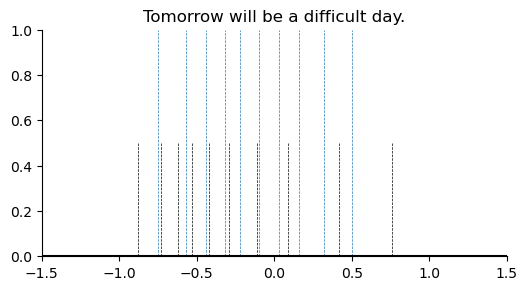

In [56]:
plot_examples(v5_stems_1, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

##### Stems (part 2)

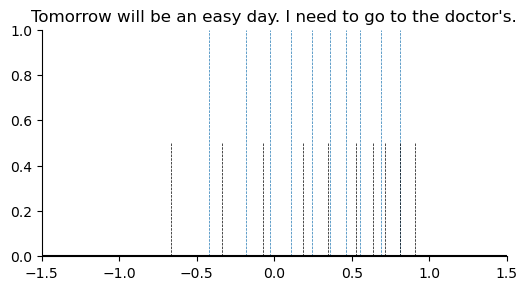

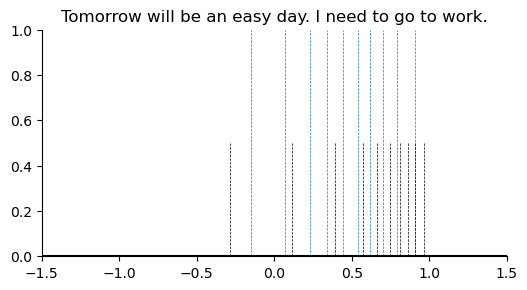

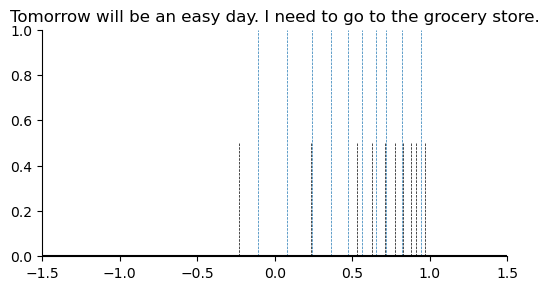

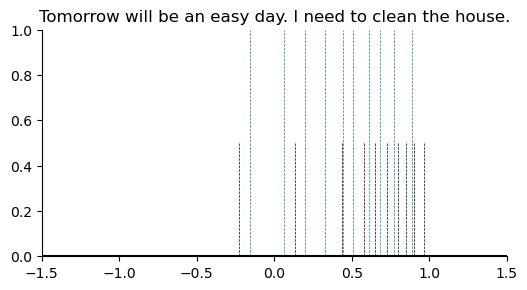

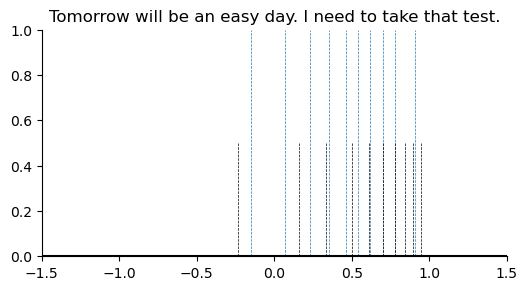

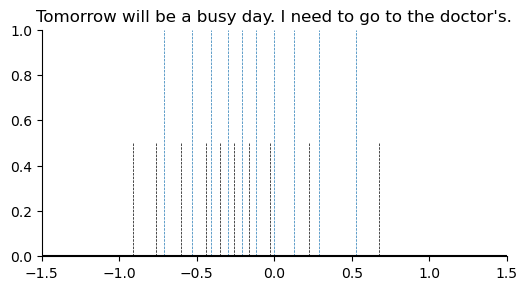

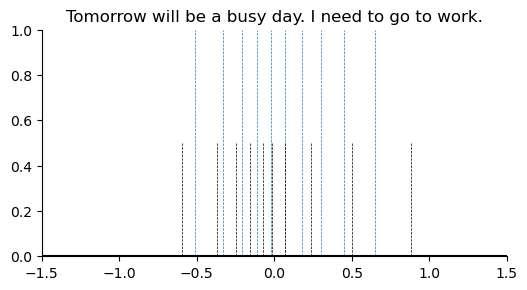

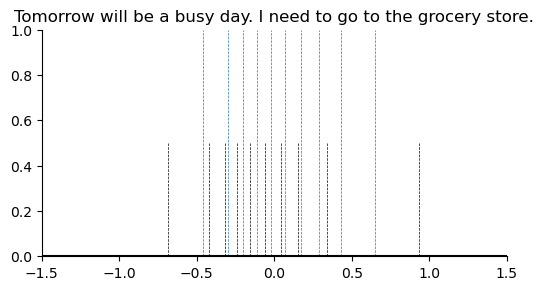

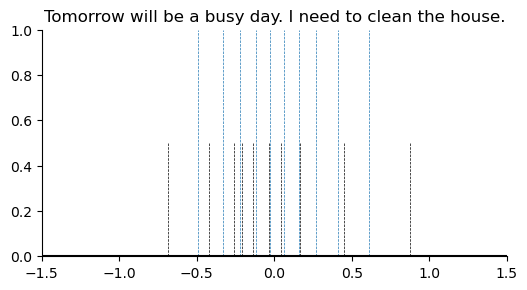

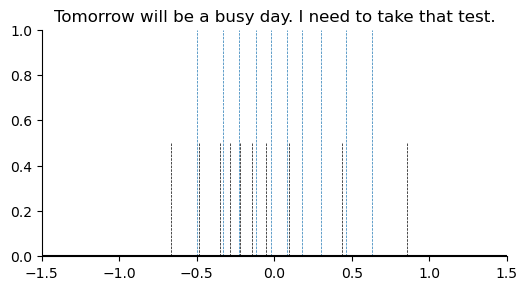

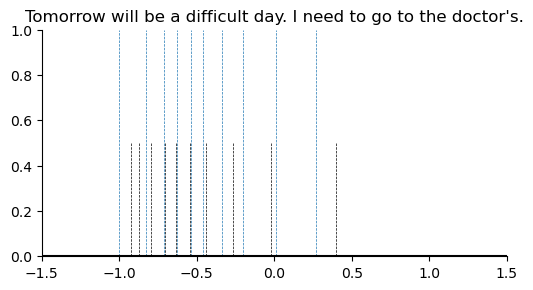

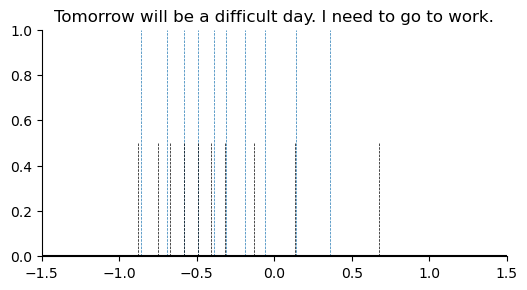

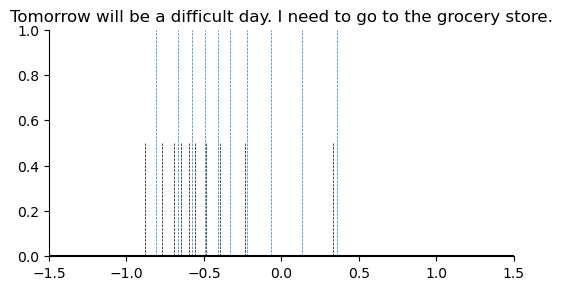

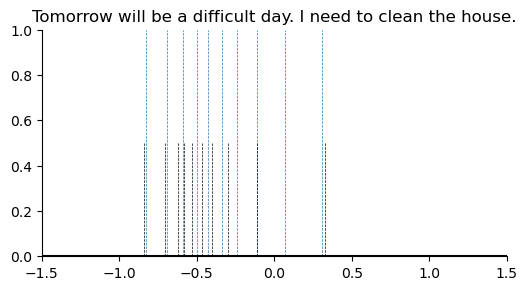

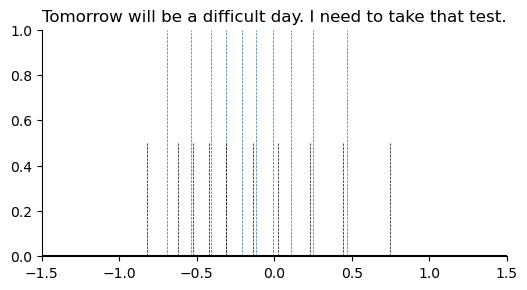

In [57]:
plot_examples(v5_stems, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

##### Random Examples

In [58]:
np.random.seed(1)
rand_examples = [s.split('p=')[0].strip() for s in np.random.choice(sentences, 10)]
rand_examples

['Tomorrow will be a difficult day. I need to go to the grocery store. I need to get my son some groceries. I need to get a car. I need to do this.',
 "Tomorrow will be an easy day. I need to go to work. I need to be there. I can't do it without you. I need to get up.",
 "Tomorrow will be a difficult day. I need to clean the house. I need to make sure everyone's OK. I need to help the people who are here. I need to make sure that we are all OK.",
 'Tomorrow will be an easy day. I need to clean the house. I need to get ready for work. I need to go for a walk. I need to take a shower.',
 "Tomorrow will be a difficult day. I need to go to the doctor's. I need to go to the hospital. I need to talk to them. I need to come home.",
 "Tomorrow will be a difficult day. I need to go to the grocery store. I need to get my medication. I need to be ready to go to school tomorrow morning. I need to be sure that I don't need to be in the hospital.",
 'Tomorrow will be an easy day. I will go on a bike

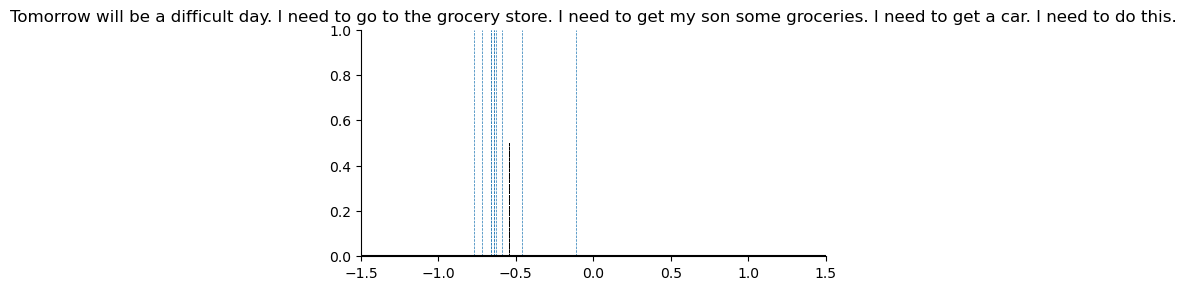

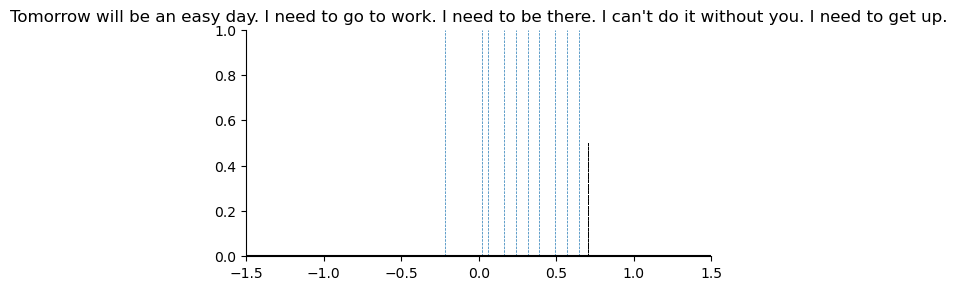

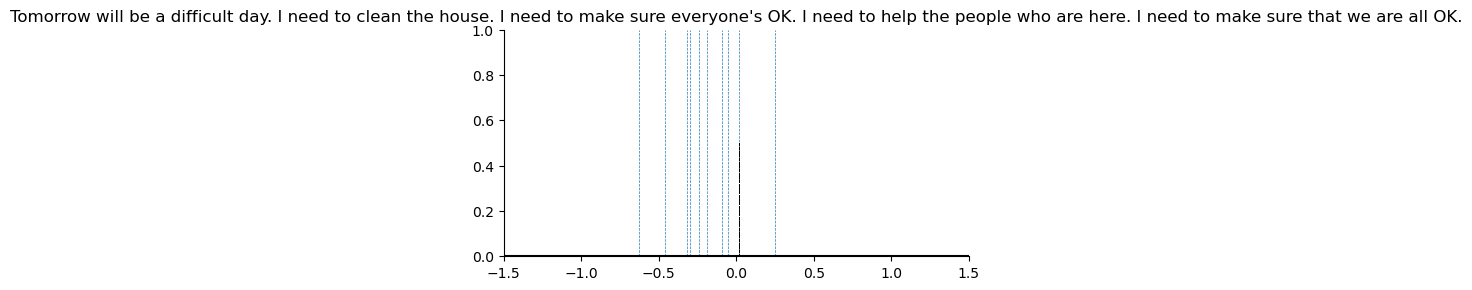

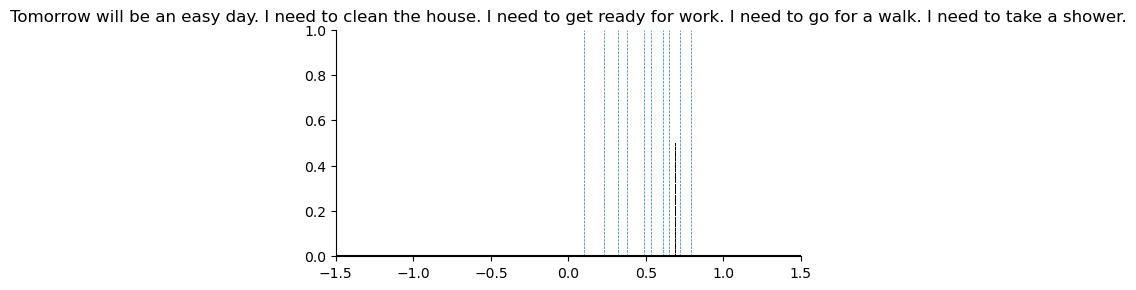

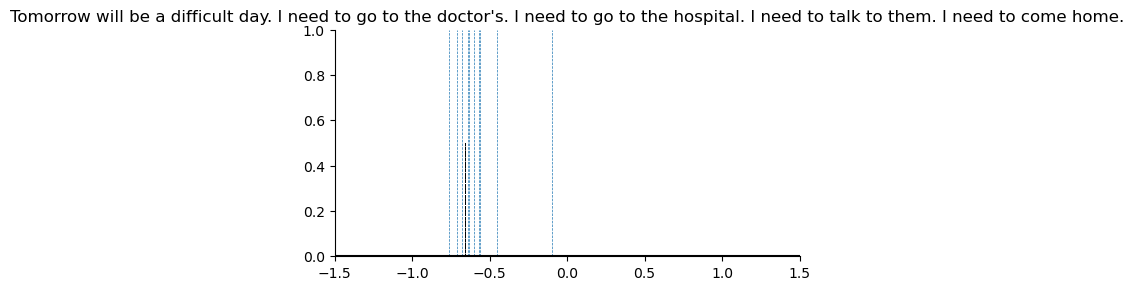

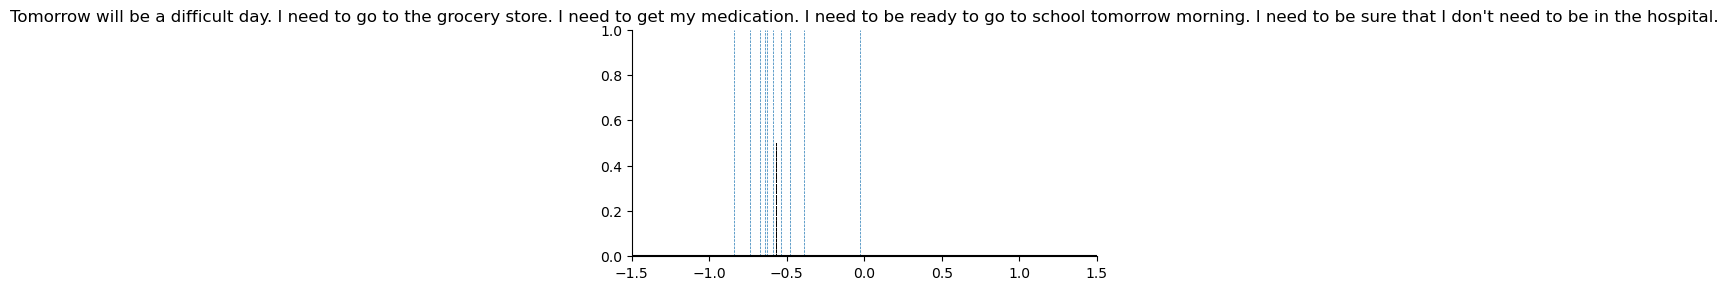

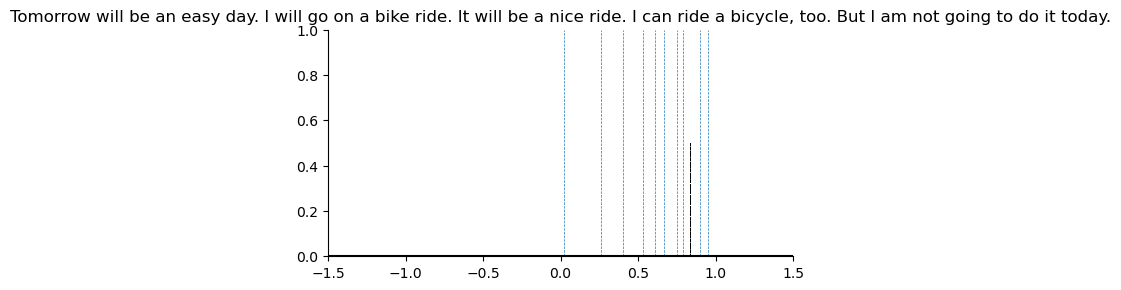

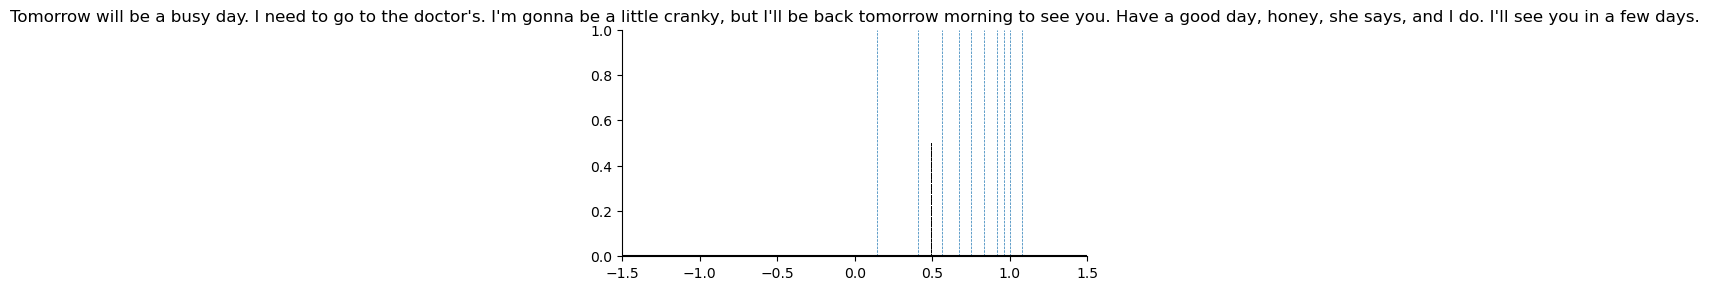

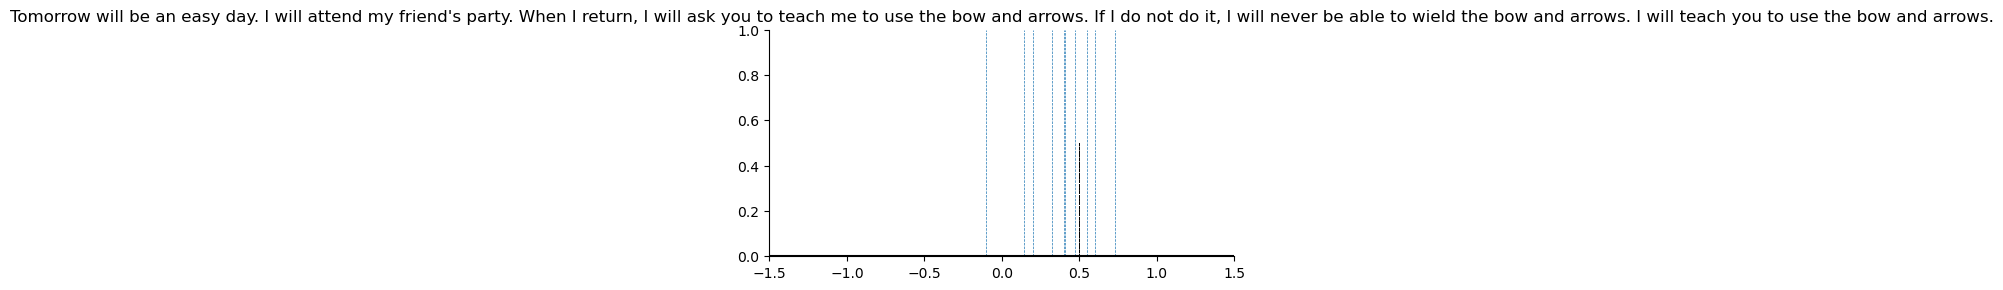

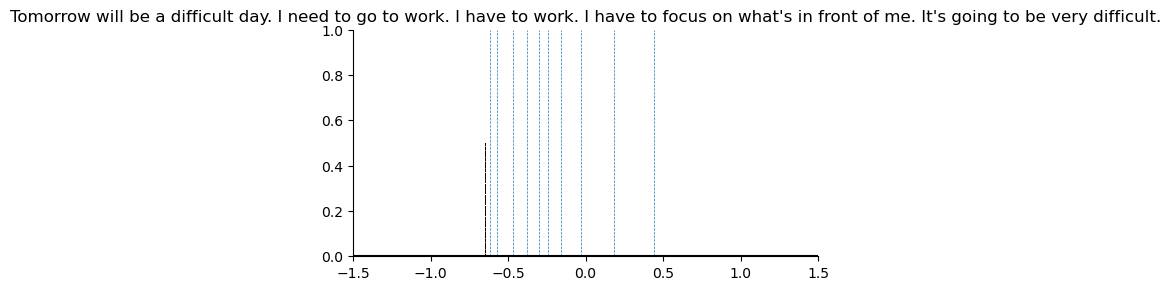

In [59]:
plot_examples(rand_examples, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

##### Manual Examples

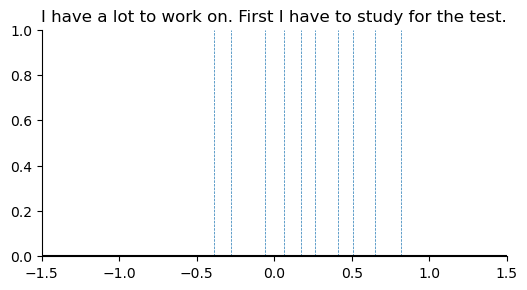

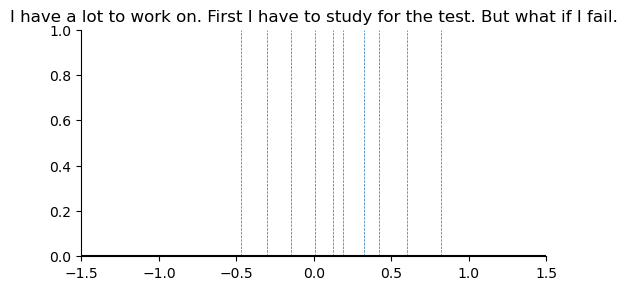

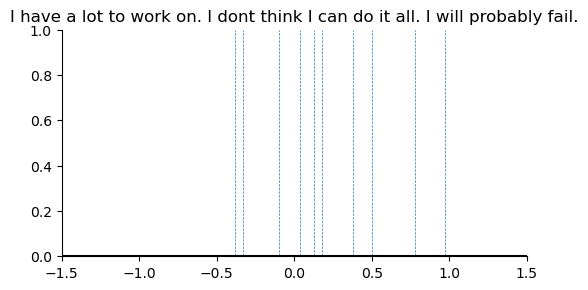

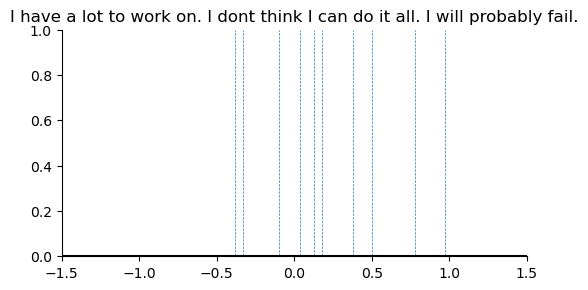

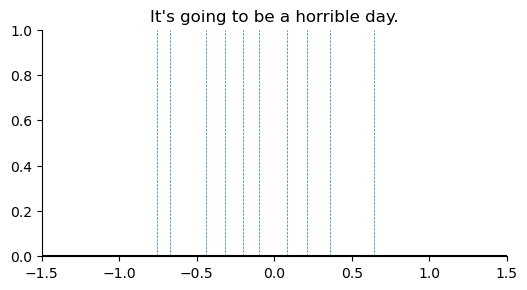

In [60]:
examples = ['I have a lot to work on. First I have to study for the test.',
            'I have a lot to work on. First I have to study for the test. But what if I fail.',
            'I have a lot to work on. I dont think I can do it all. I will probably fail.',
            'I have a lot to work on. I dont think I can do it all. I will probably fail.',
            "It's going to be a horrible day.",
           ]

plot_examples(examples, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

#### 100 Hidden Units (48 Epochs) (faster lr)

In [101]:
out = load_rl_model(epoch=48, hidden_dim =100, n_quantiles = 10, extra = '_composite_rewards',
                          folder = 'sentence_chains_I_5',huber=0.1)

In [102]:
v5_stems_1 =["Tomorrow will be an easy day.",
           "Tomorrow will be a busy day.",
           "Tomorrow will be a difficult day."]
v5_stems_2 = ["I need to go to the doctor's.", 'I need to go to work.', 
         'I need to go to the grocery store.', 'I need to clean the house.',  'I need to take that test.']

v5_stems = []
for v5_1 in v5_stems_1:
    for v5_2 in v5_stems_2:
        v5_stems.append(v5_1+' '+v5_2)

In [103]:
v5_stems[0:2]

["Tomorrow will be an easy day. I need to go to the doctor's.",
 'Tomorrow will be an easy day. I need to go to work.']

##### Tracked Sentences

In [64]:
tracked_sentences = [key for key in out['log'].keys() if key not in ['loss','epoch']]

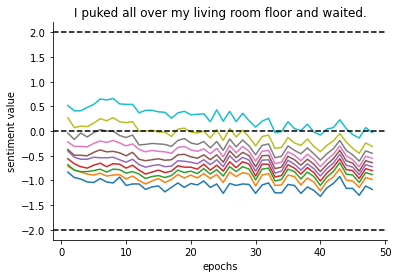

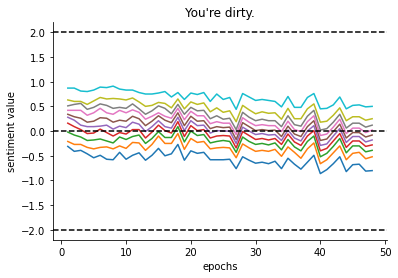

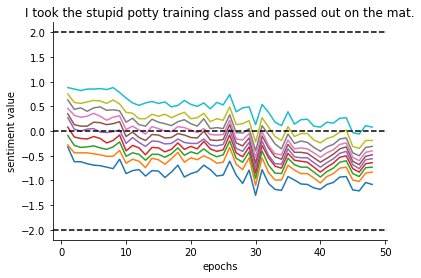

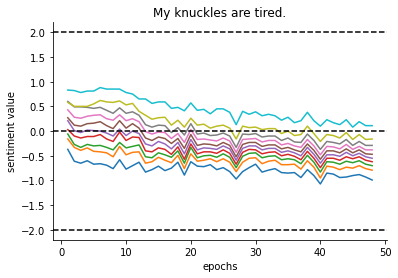

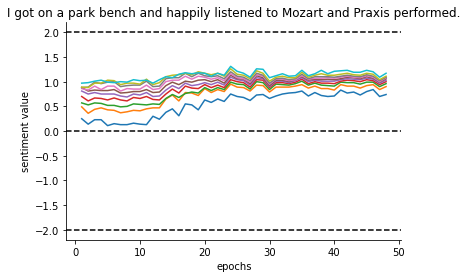

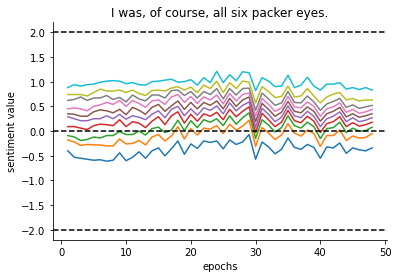

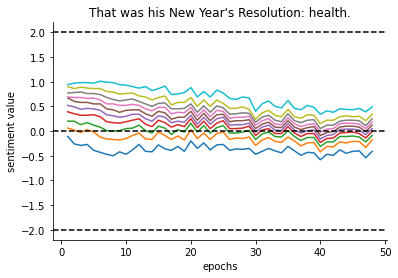

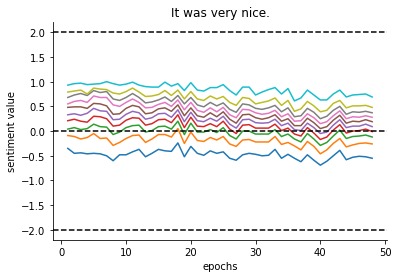

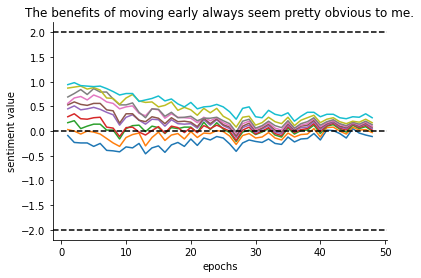

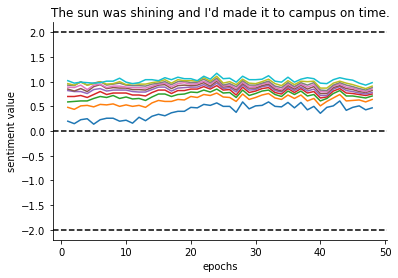

In [65]:
for sent in tracked_sentences:
    plt.figure()
    plt.plot(out['epoch'], np.array(out['log'][sent]))
    sns.despine()
    plt.axhline(y=-2, color='k', linestyle='--')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.axhline(y=2, color='k', linestyle='--')
    plt.ylabel('sentiment value')
    plt.xlabel('epochs')
    plt.title(sent)

##### Stems (part 1)

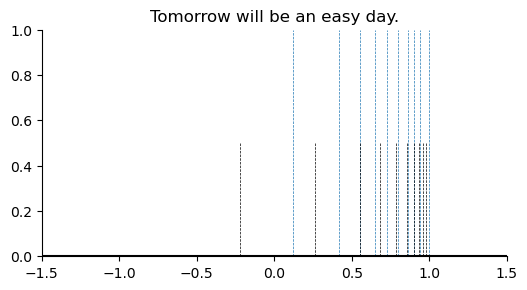

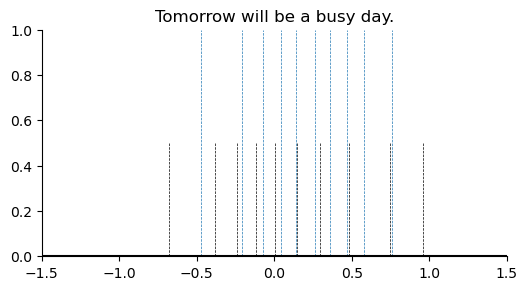

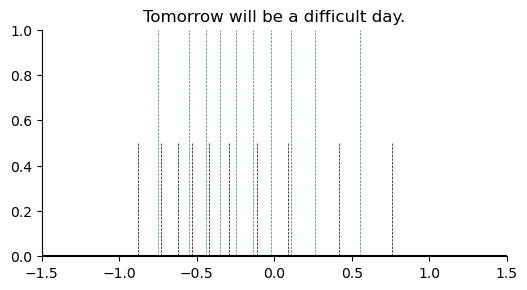

In [66]:
plot_examples(v5_stems_1, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

##### Stems (part 2)

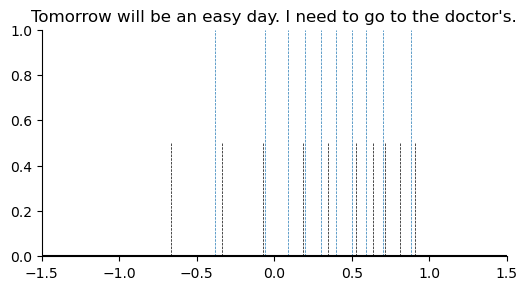

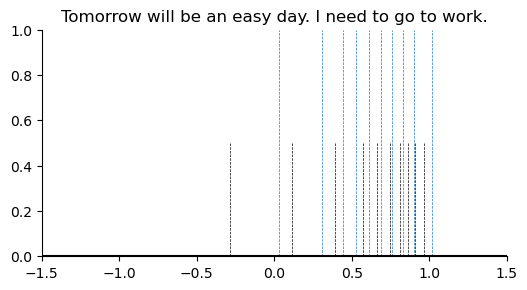

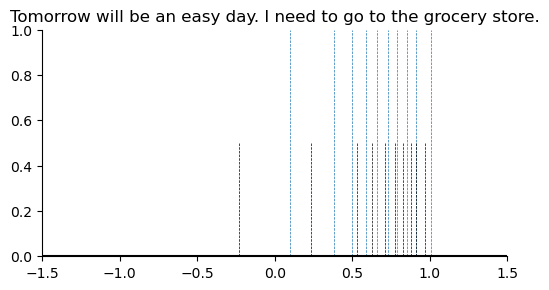

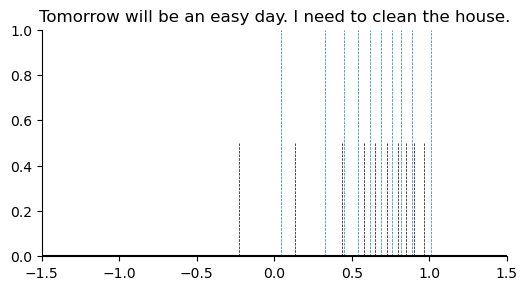

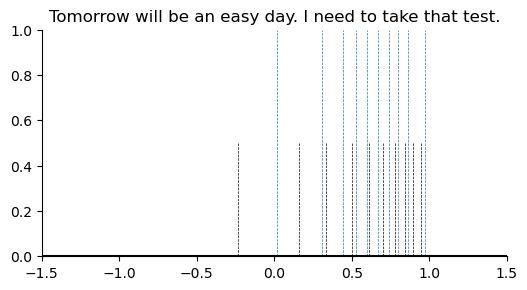

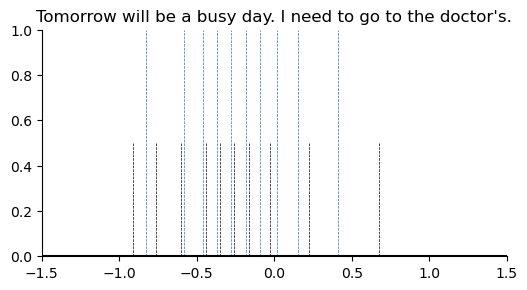

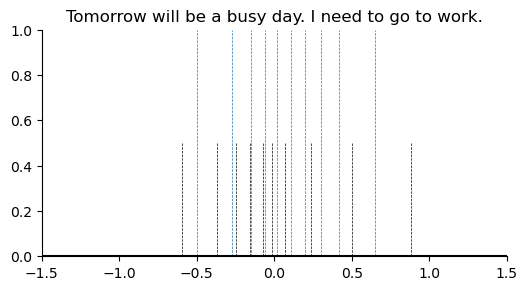

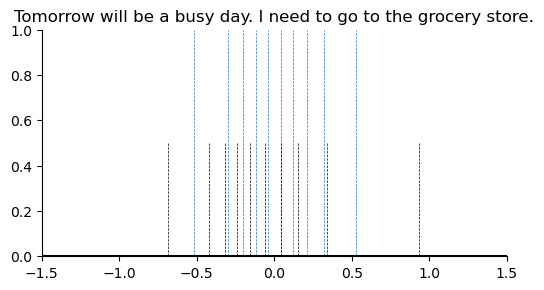

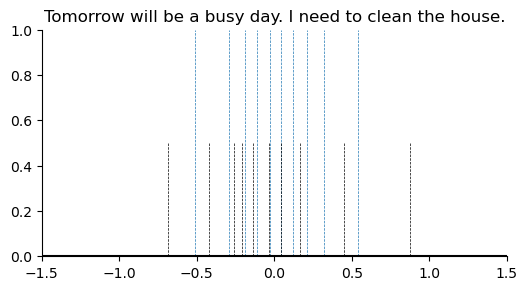

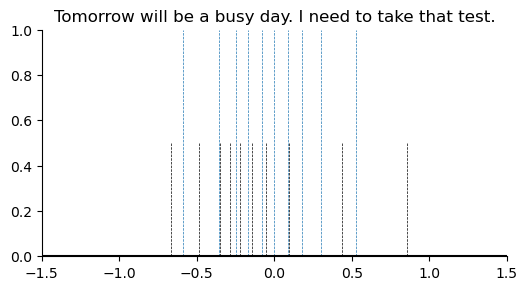

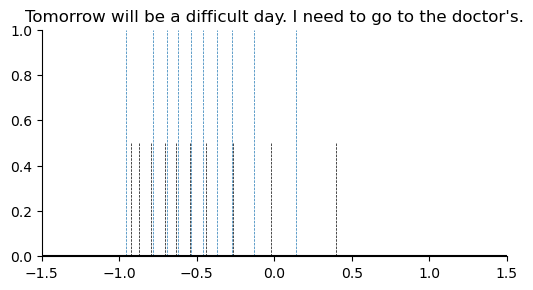

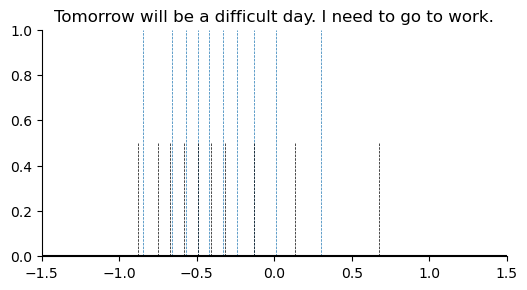

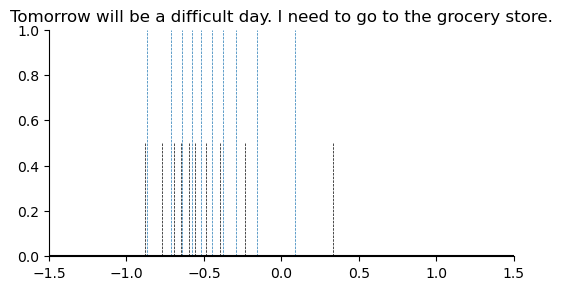

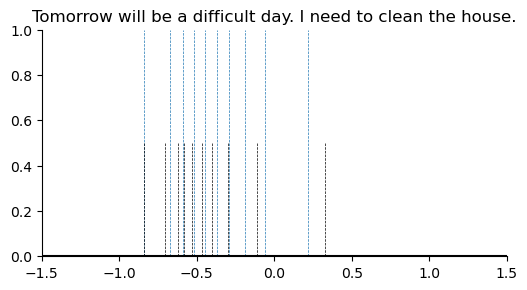

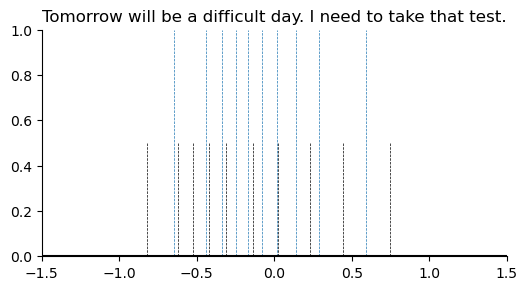

In [67]:
plot_examples(v5_stems, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

##### Random Examples

In [68]:
np.random.seed(1)
rand_examples = [s.split('p=')[0].strip() for s in np.random.choice(sentences, 10)]
rand_examples

['Tomorrow will be a difficult day. I need to go to the grocery store. I need to get my son some groceries. I need to get a car. I need to do this.',
 "Tomorrow will be an easy day. I need to go to work. I need to be there. I can't do it without you. I need to get up.",
 "Tomorrow will be a difficult day. I need to clean the house. I need to make sure everyone's OK. I need to help the people who are here. I need to make sure that we are all OK.",
 'Tomorrow will be an easy day. I need to clean the house. I need to get ready for work. I need to go for a walk. I need to take a shower.',
 "Tomorrow will be a difficult day. I need to go to the doctor's. I need to go to the hospital. I need to talk to them. I need to come home.",
 "Tomorrow will be a difficult day. I need to go to the grocery store. I need to get my medication. I need to be ready to go to school tomorrow morning. I need to be sure that I don't need to be in the hospital.",
 'Tomorrow will be an easy day. I will go on a bike

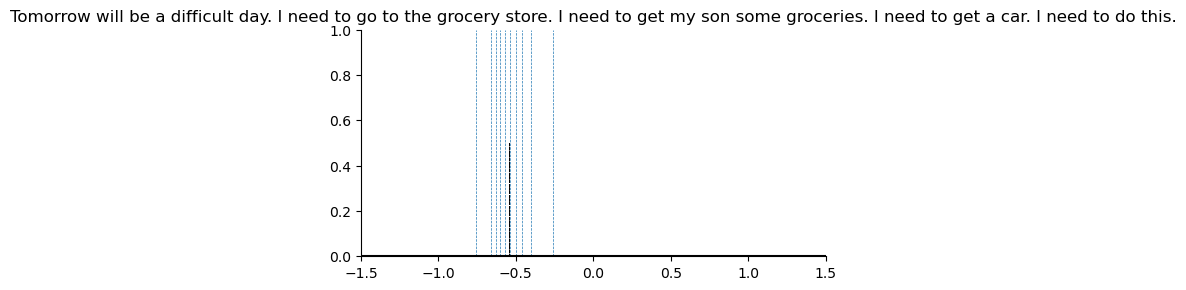

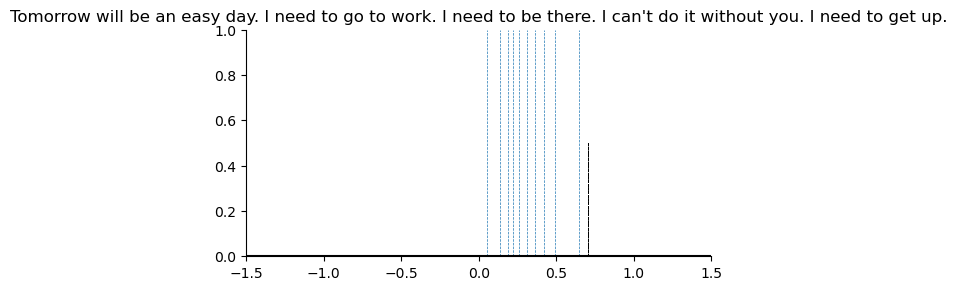

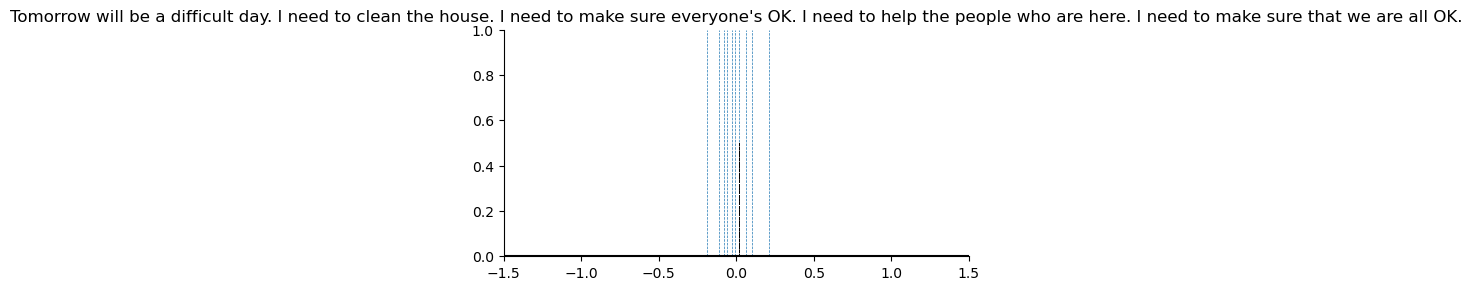

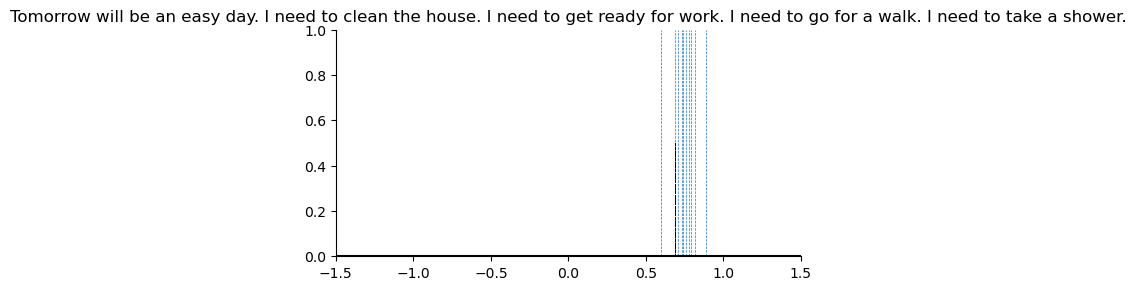

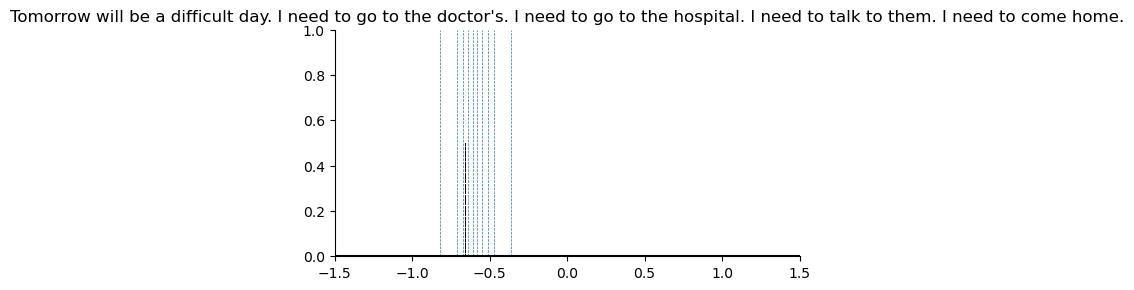

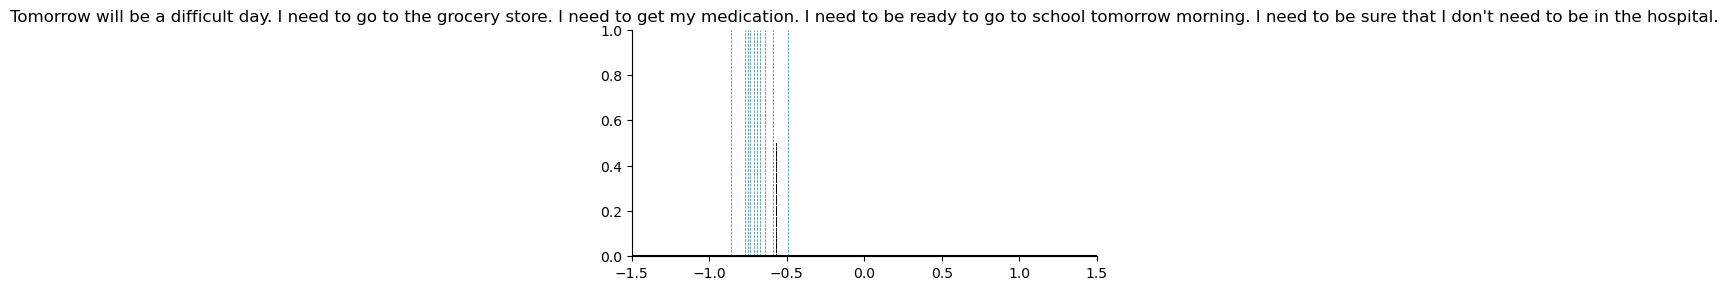

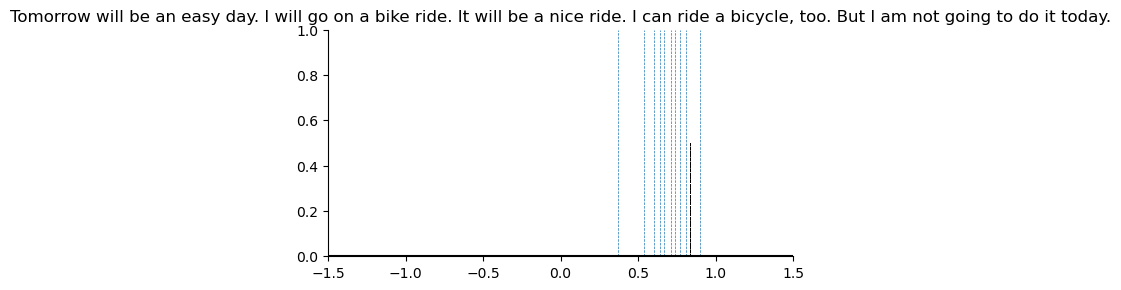

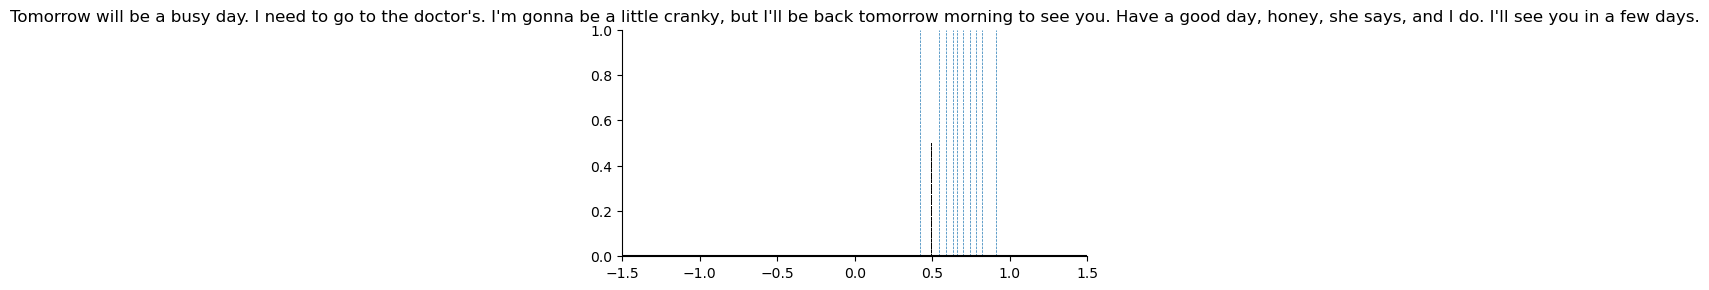

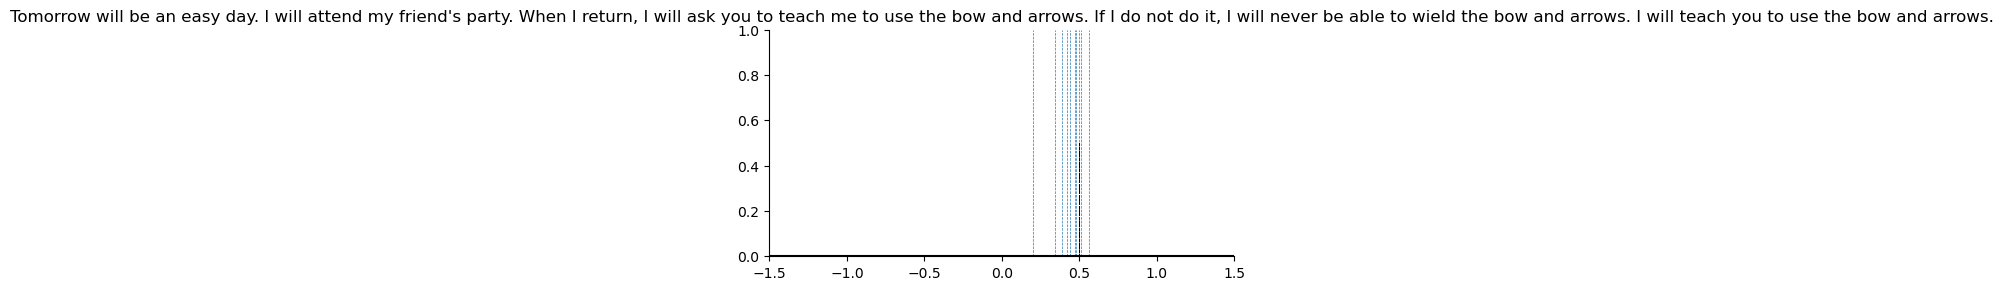

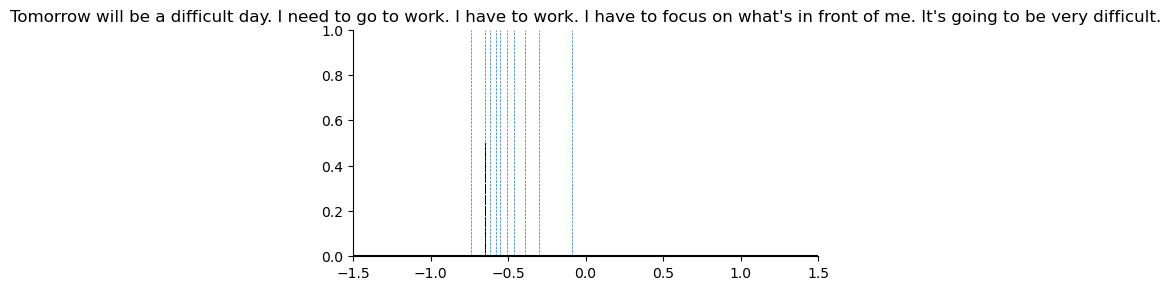

In [69]:
plot_examples(rand_examples, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

##### Manual Examples

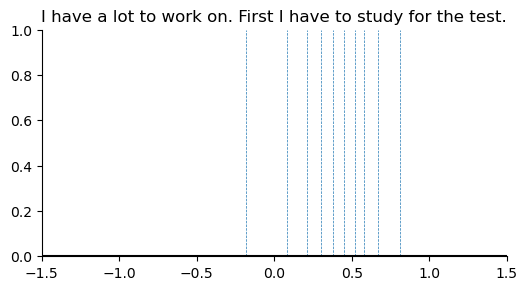

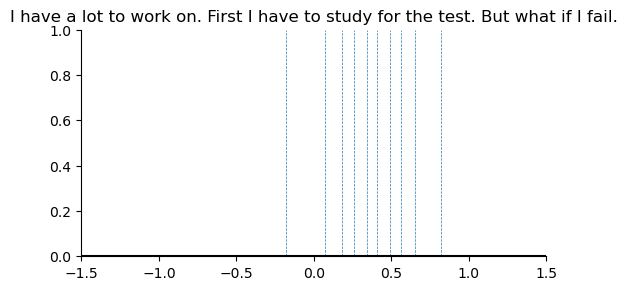

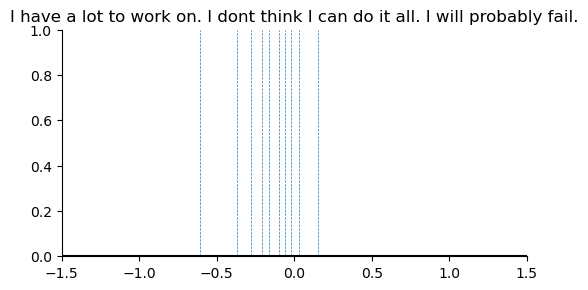

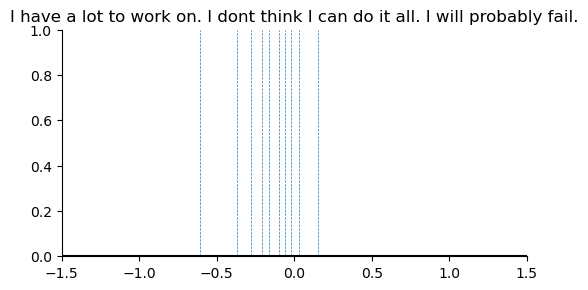

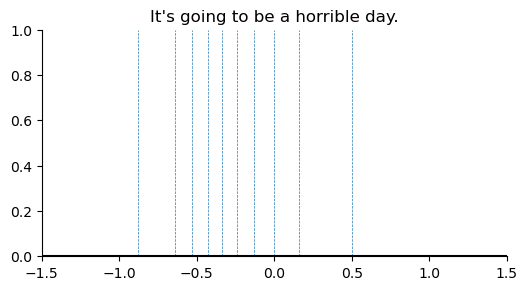

In [70]:
examples = ['I have a lot to work on. First I have to study for the test.',
            'I have a lot to work on. First I have to study for the test. But what if I fail.',
            'I have a lot to work on. I dont think I can do it all. I will probably fail.',
            'I have a lot to work on. I dont think I can do it all. I will probably fail.',
            "It's going to be a horrible day.",
           ]

plot_examples(examples, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

##### Extra

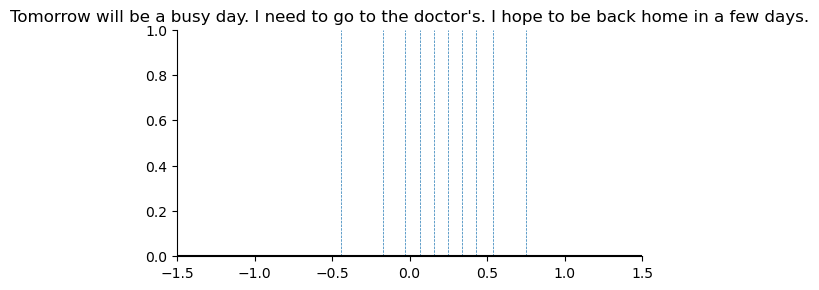

In [104]:
examples = ["Tomorrow will be a busy day. I need to go to the doctor's. I hope to be back home in a few days."
           ]f

plot_examples(examples, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

#### 10 Hidden Units (20 Epochs)

In [71]:
out = load_rl_model(epoch=19, hidden_dim =10, n_quantiles = 10, extra = '_composite_rewards_slow_lr',
                          folder = 'sentence_chains_I_5',huber=0.1)

In [72]:
v5_stems_1 =["Tomorrow will be an easy day.",
           "Tomorrow will be a busy day.",
           "Tomorrow will be a difficult day."]
v5_stems_2 = ["I need to go to the doctor's.", 'I need to go to work.', 
         'I need to go to the grocery store.', 'I need to clean the house.',  'I need to take that test.']

v5_stems = []
for v5_1 in v5_stems_1:
    for v5_2 in v5_stems_2:
        v5_stems.append(v5_1+' '+v5_2)

In [73]:
v5_stems[0:2]

["Tomorrow will be an easy day. I need to go to the doctor's.",
 'Tomorrow will be an easy day. I need to go to work.']

##### Tracked Sentences

In [74]:
tracked_sentences = [key for key in out['log'].keys() if key not in ['loss','epoch']]

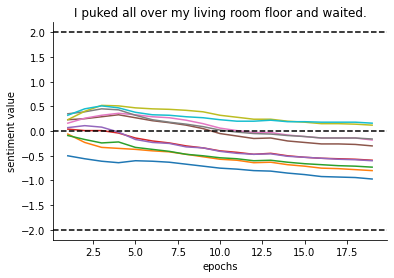

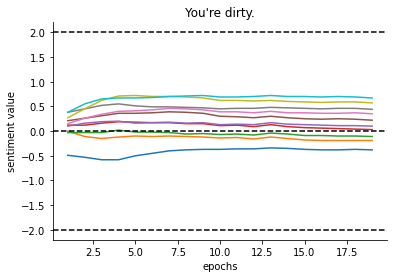

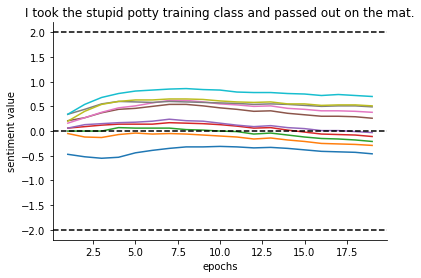

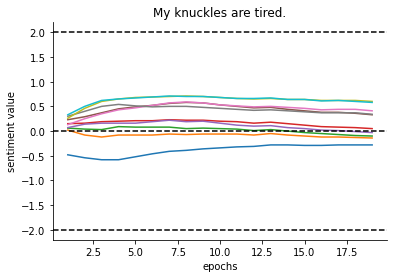

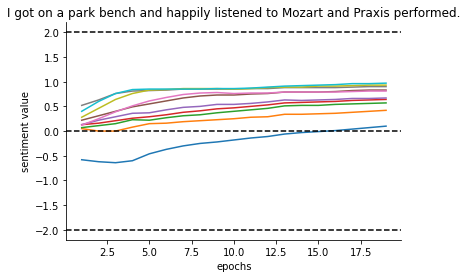

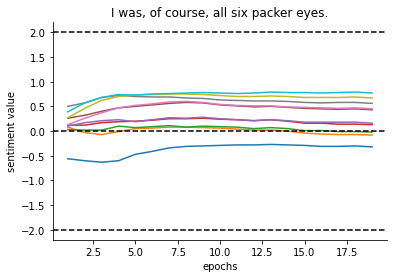

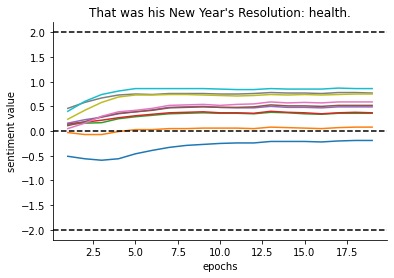

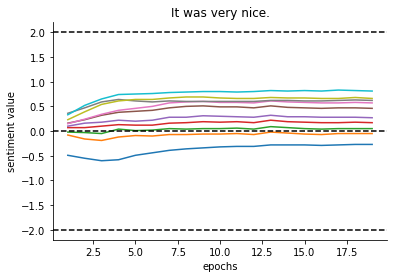

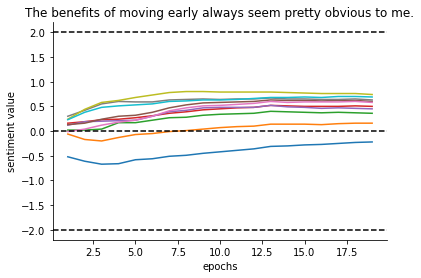

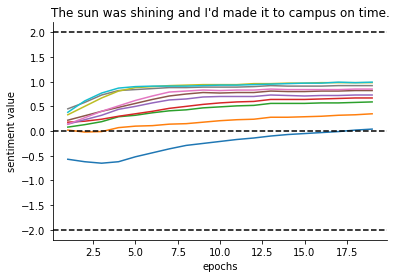

In [75]:
for sent in tracked_sentences:
    plt.figure()
    plt.plot(out['epoch'], np.array(out['log'][sent]))
    sns.despine()
    plt.axhline(y=-2, color='k', linestyle='--')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.axhline(y=2, color='k', linestyle='--')
    plt.ylabel('sentiment value')
    plt.xlabel('epochs')
    plt.title(sent)

##### Stems (part 1)

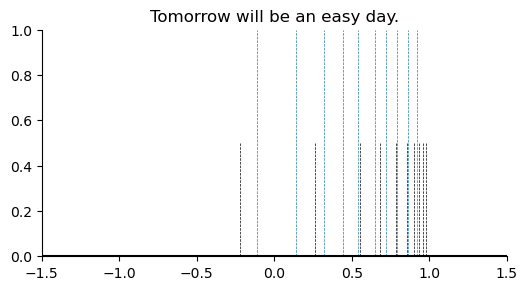

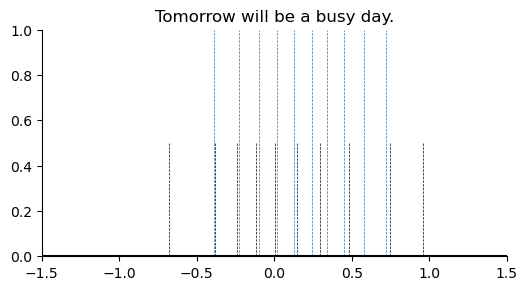

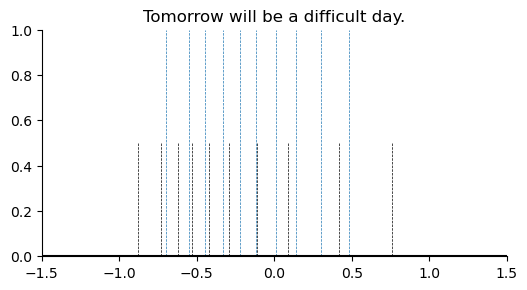

In [76]:
plot_examples(v5_stems_1, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

##### Stems (part 2)

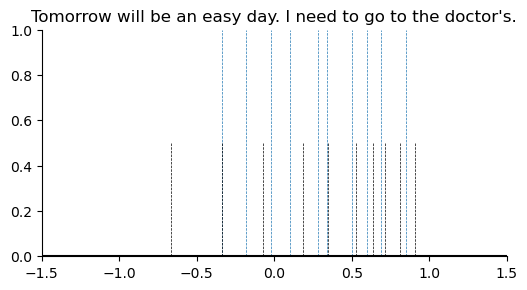

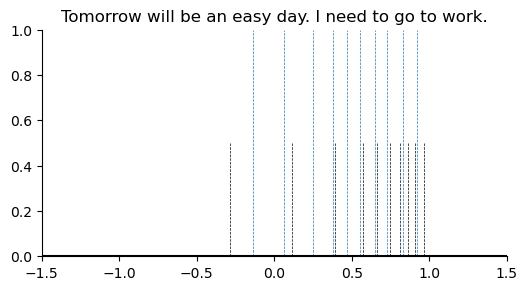

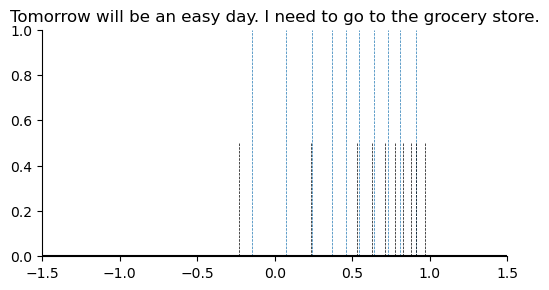

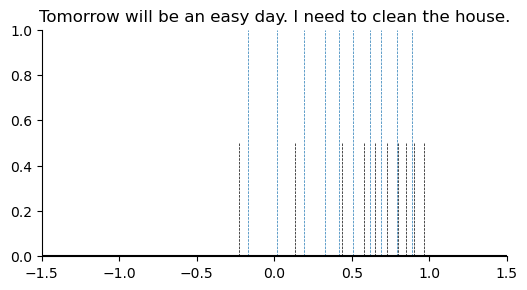

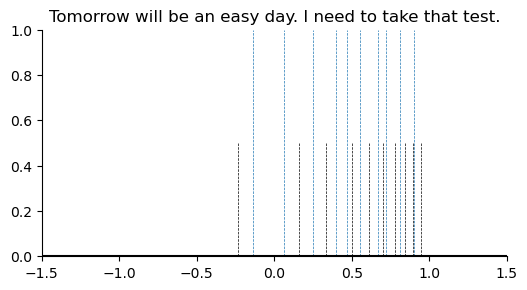

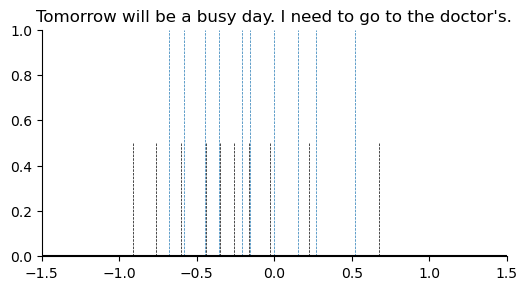

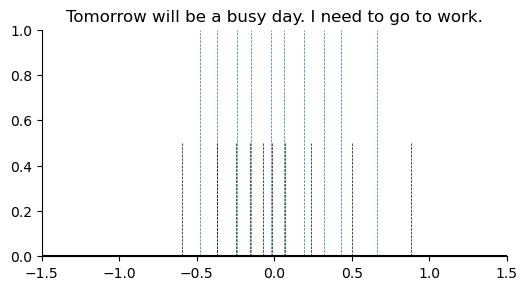

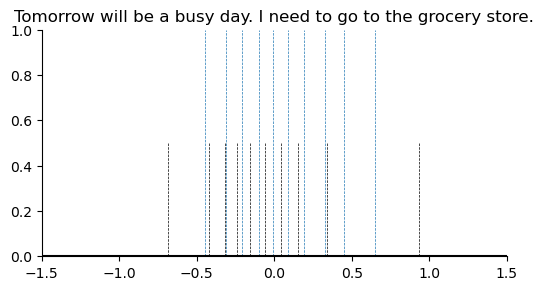

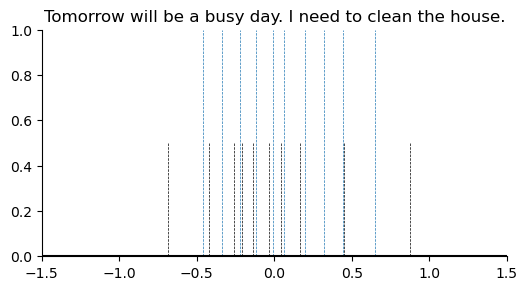

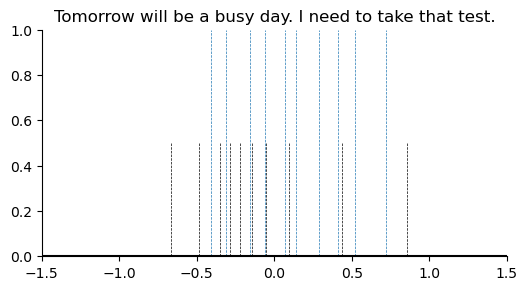

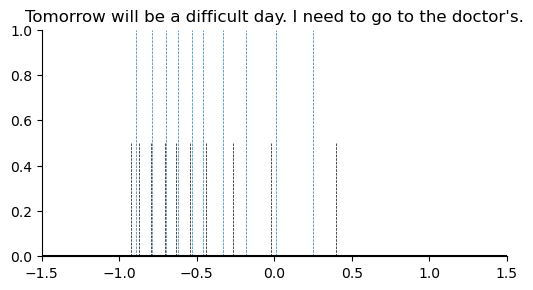

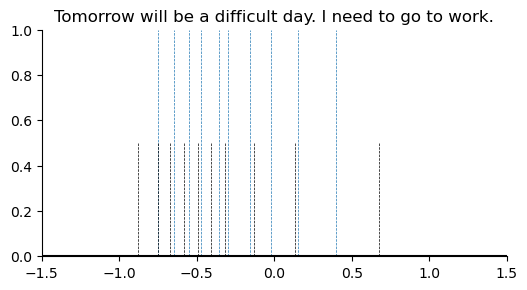

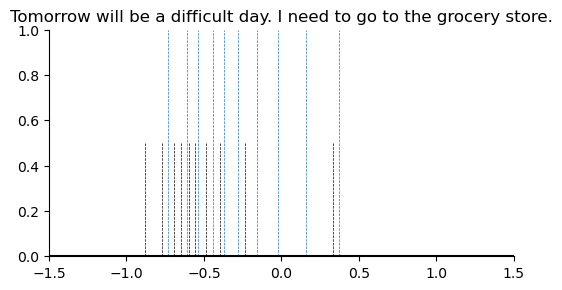

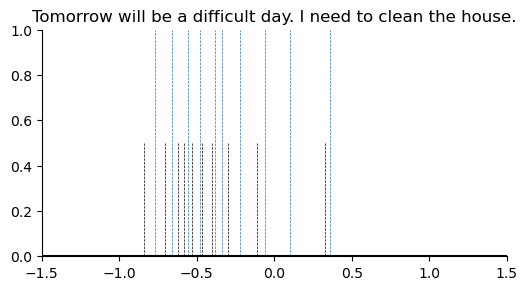

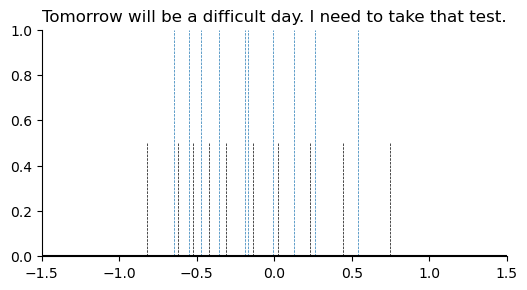

In [77]:
plot_examples(v5_stems, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

##### Random Examples

In [78]:
np.random.seed(1)
rand_examples = [s.split('p=')[0].strip() for s in np.random.choice(sentences, 10)]
rand_examples

['Tomorrow will be a difficult day. I need to go to the grocery store. I need to get my son some groceries. I need to get a car. I need to do this.',
 "Tomorrow will be an easy day. I need to go to work. I need to be there. I can't do it without you. I need to get up.",
 "Tomorrow will be a difficult day. I need to clean the house. I need to make sure everyone's OK. I need to help the people who are here. I need to make sure that we are all OK.",
 'Tomorrow will be an easy day. I need to clean the house. I need to get ready for work. I need to go for a walk. I need to take a shower.',
 "Tomorrow will be a difficult day. I need to go to the doctor's. I need to go to the hospital. I need to talk to them. I need to come home.",
 "Tomorrow will be a difficult day. I need to go to the grocery store. I need to get my medication. I need to be ready to go to school tomorrow morning. I need to be sure that I don't need to be in the hospital.",
 'Tomorrow will be an easy day. I will go on a bike

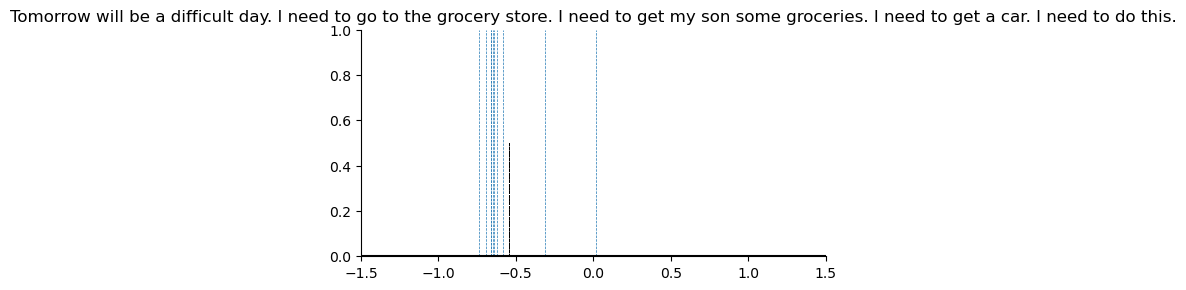

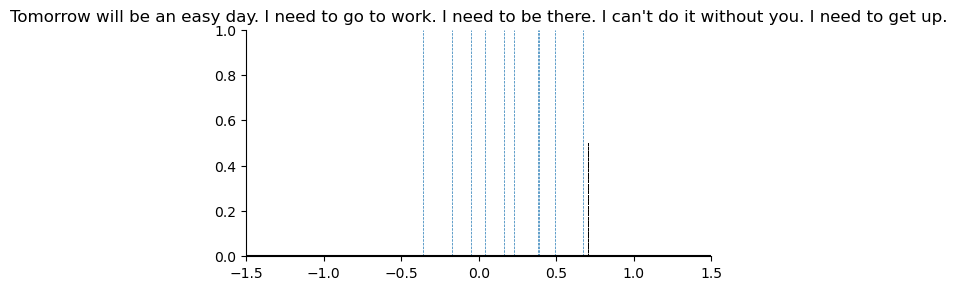

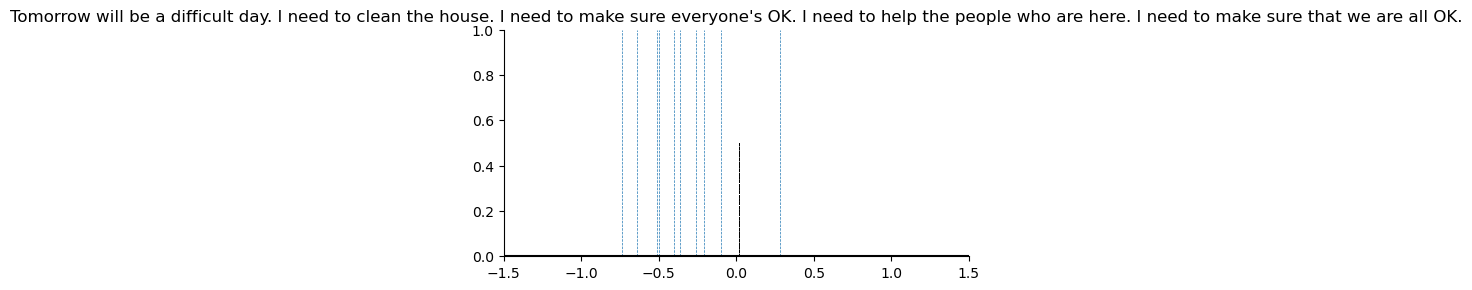

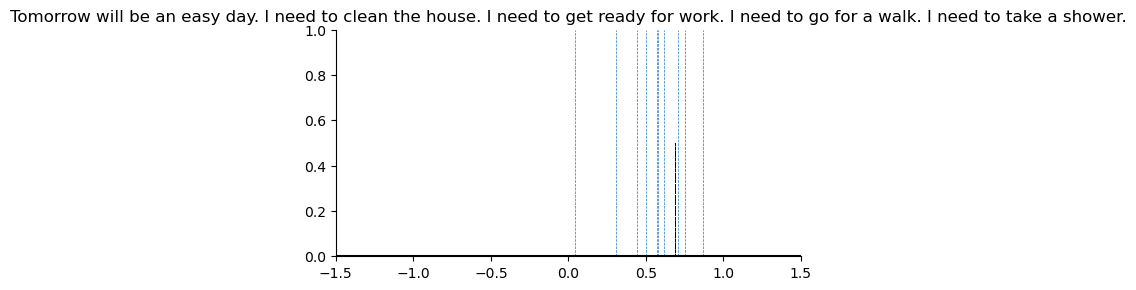

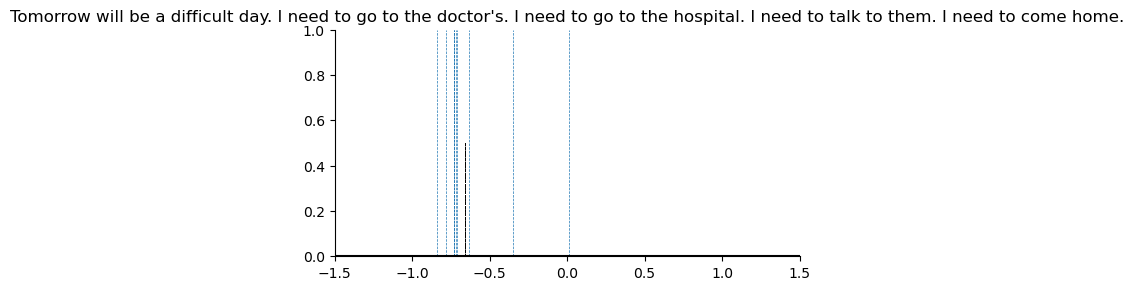

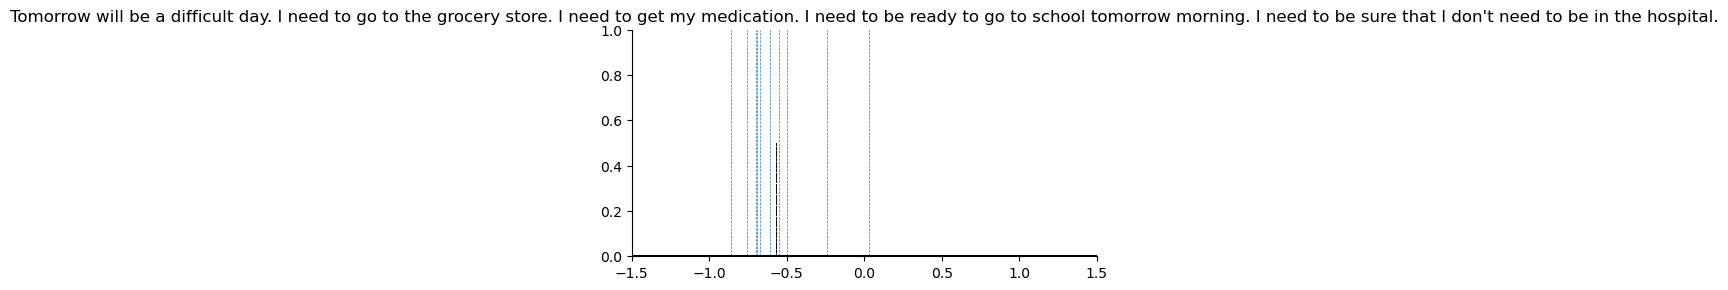

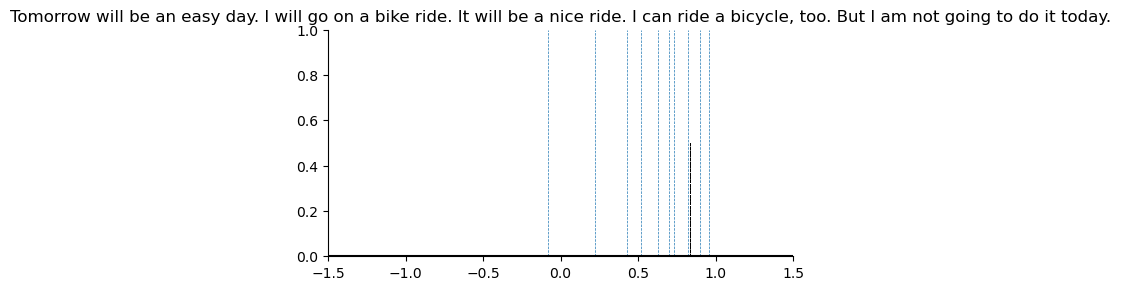

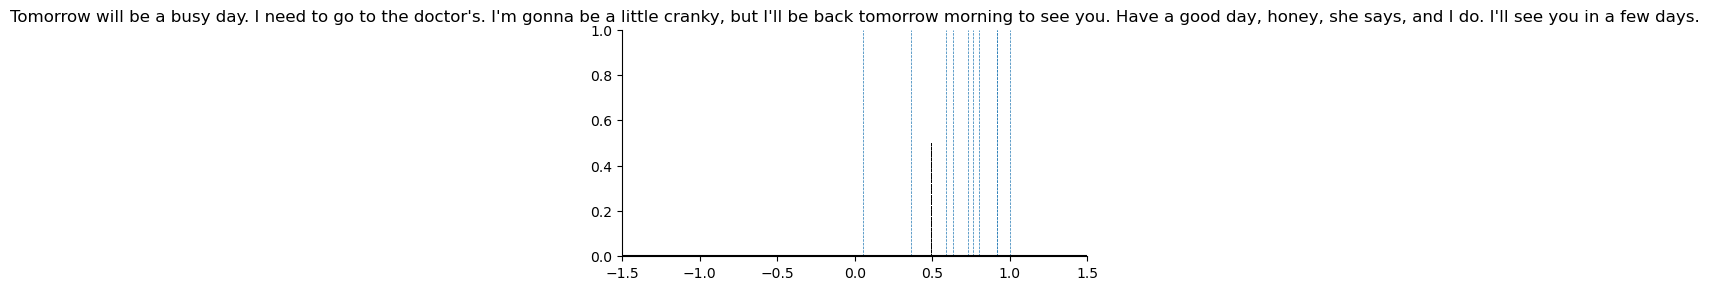

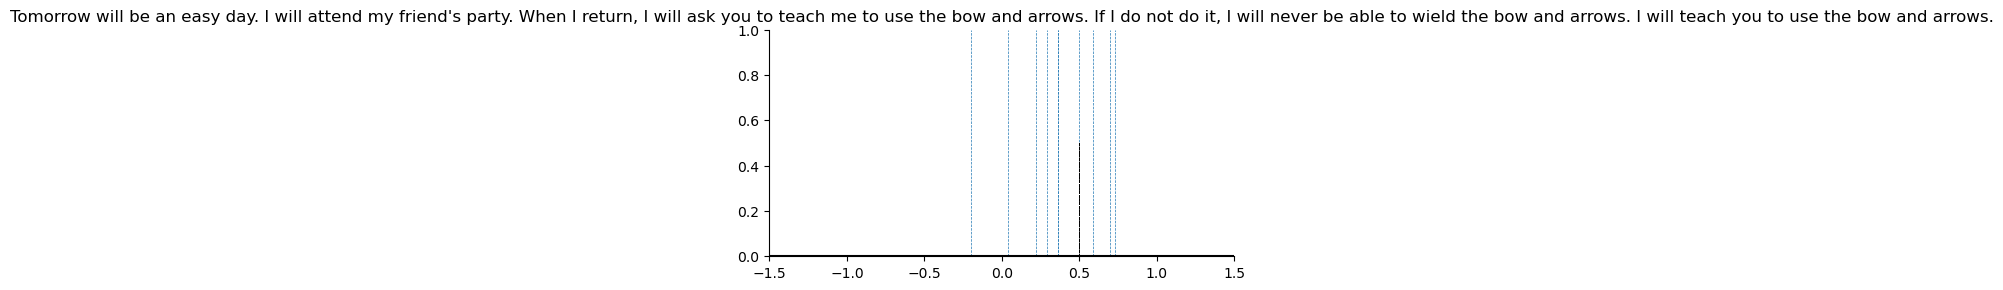

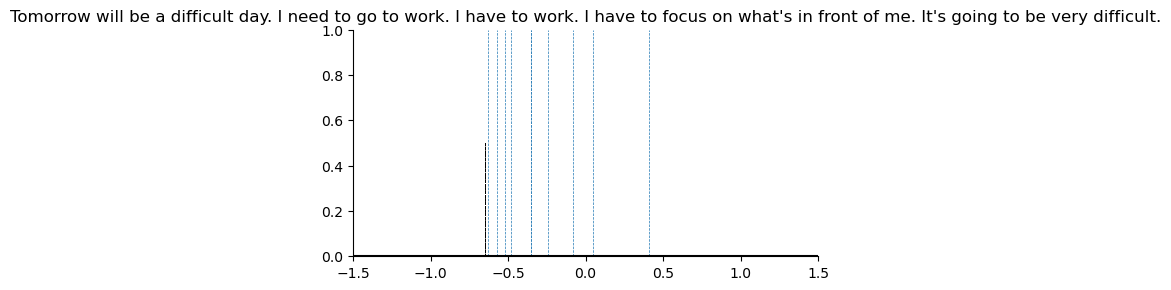

In [79]:
plot_examples(rand_examples, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

##### Manual Examples

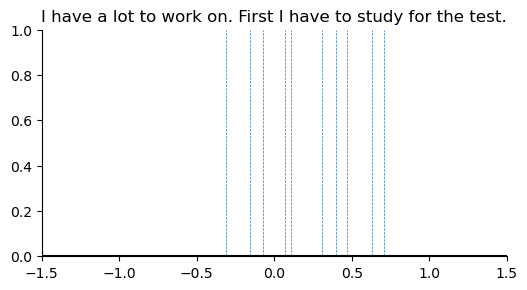

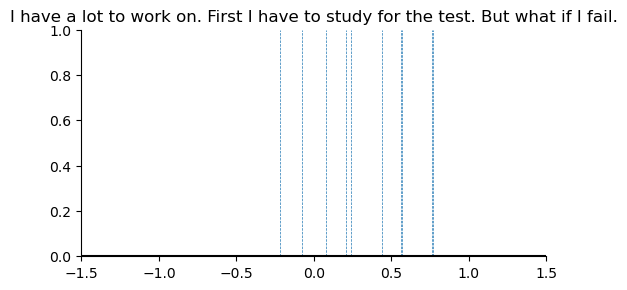

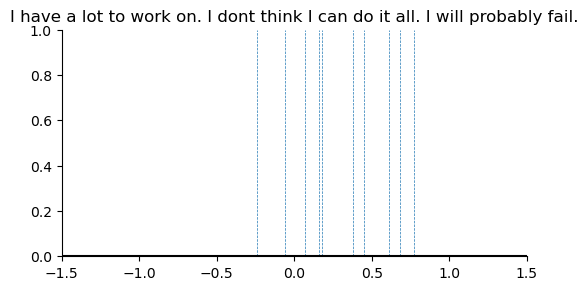

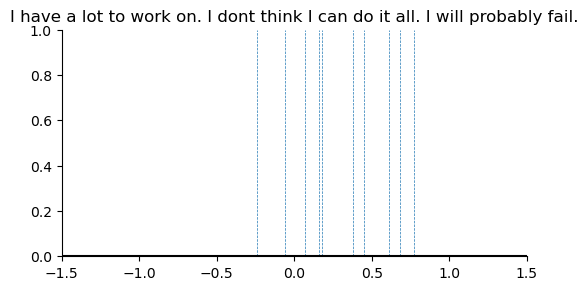

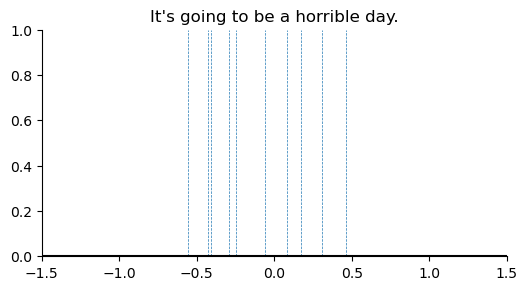

In [80]:
examples = ['I have a lot to work on. First I have to study for the test.',
            'I have a lot to work on. First I have to study for the test. But what if I fail.',
            'I have a lot to work on. I dont think I can do it all. I will probably fail.',
            'I have a lot to work on. I dont think I can do it all. I will probably fail.',
            "It's going to be a horrible day.",
           ]

plot_examples(examples, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

#### 10 Hidden Units (48 Epochs) (faster lr)

In [91]:
out = load_rl_model(epoch=48, hidden_dim =10, n_quantiles = 10, extra = '_composite_rewards',
                          folder = 'sentence_chains_I_5',huber=0.1)

In [92]:
v5_stems_1 =["Tomorrow will be an easy day.",
           "Tomorrow will be a busy day.",
           "Tomorrow will be a difficult day."]
v5_stems_2 = ["I need to go to the doctor's.", 'I need to go to work.', 
         'I need to go to the grocery store.', 'I need to clean the house.',  'I need to take that test.']

v5_stems = []
for v5_1 in v5_stems_1:
    for v5_2 in v5_stems_2:
        v5_stems.append(v5_1+' '+v5_2)

In [93]:
v5_stems[0:2]

["Tomorrow will be an easy day. I need to go to the doctor's.",
 'Tomorrow will be an easy day. I need to go to work.']

##### Tracked Sentences

In [94]:
tracked_sentences = [key for key in out['log'].keys() if key not in ['loss','epoch']]

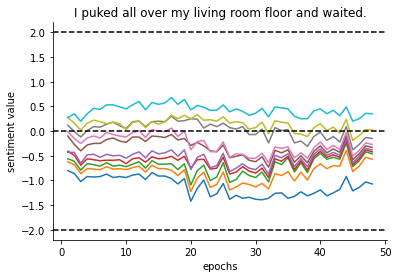

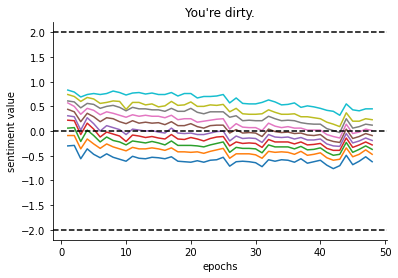

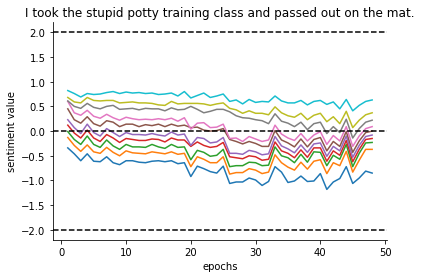

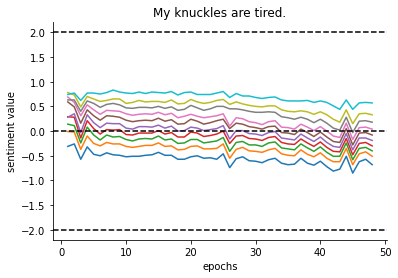

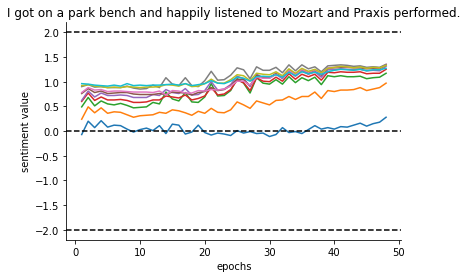

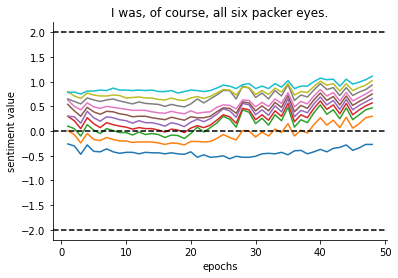

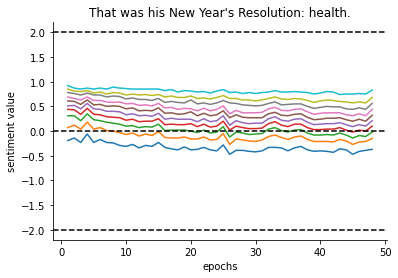

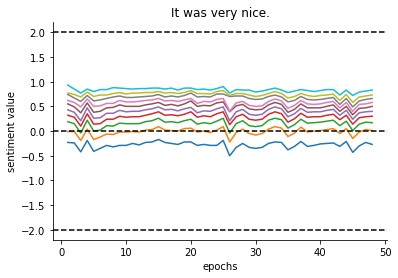

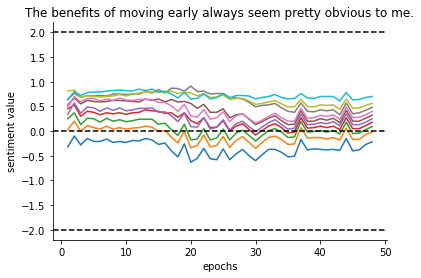

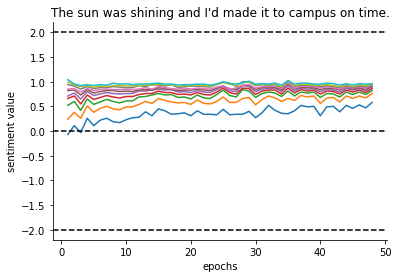

In [95]:
for sent in tracked_sentences:
    plt.figure()
    plt.plot(out['epoch'], np.array(out['log'][sent]))
    sns.despine()
    plt.axhline(y=-2, color='k', linestyle='--')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.axhline(y=2, color='k', linestyle='--')
    plt.ylabel('sentiment value')
    plt.xlabel('epochs')
    plt.title(sent)

##### Stems (part 1)

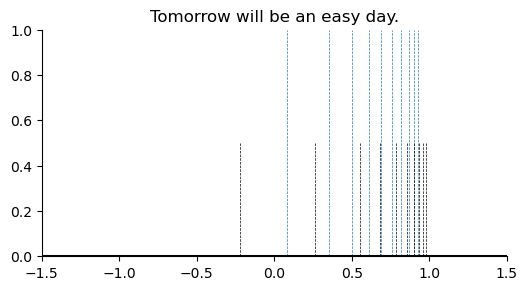

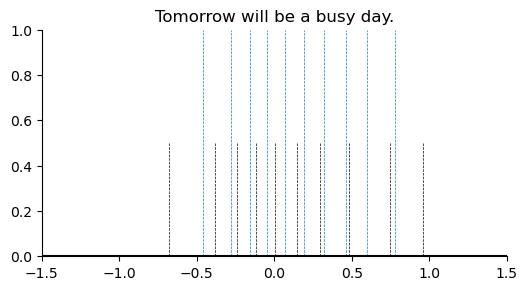

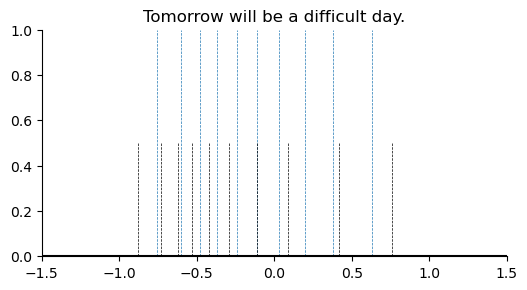

In [96]:
plot_examples(v5_stems_1, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

##### Stems (part 2)

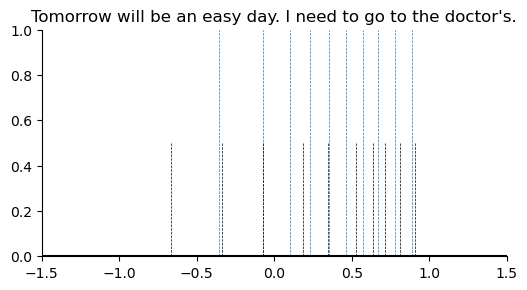

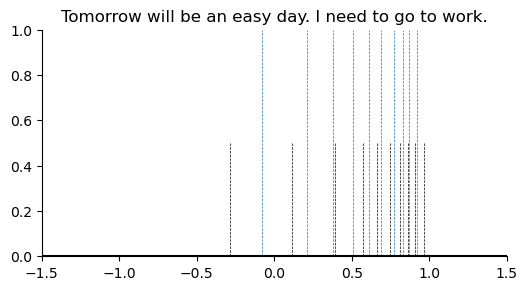

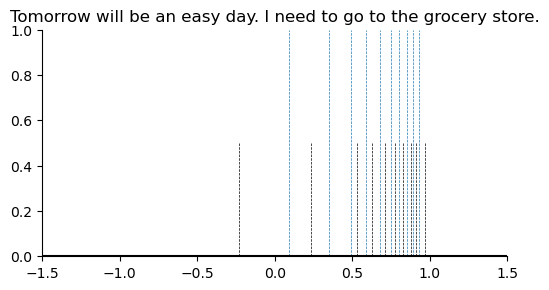

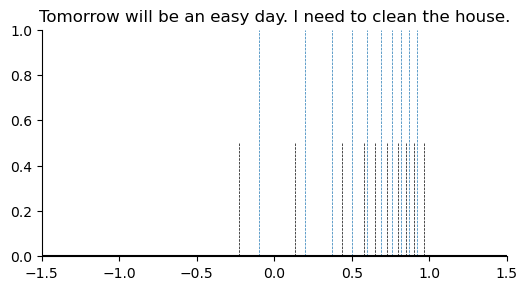

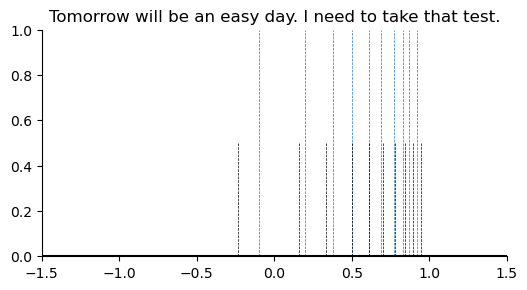

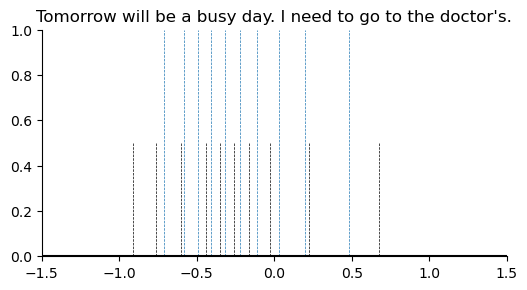

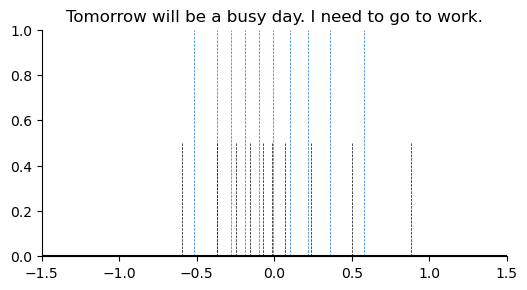

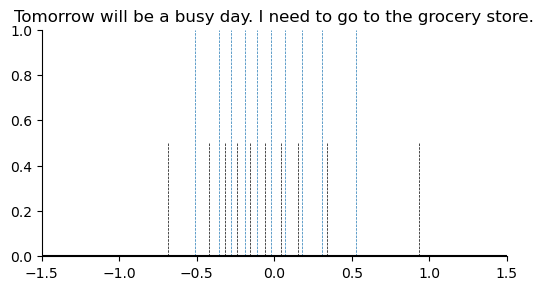

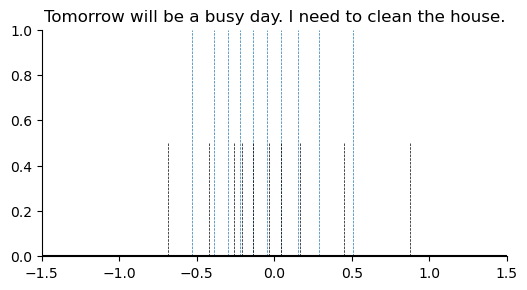

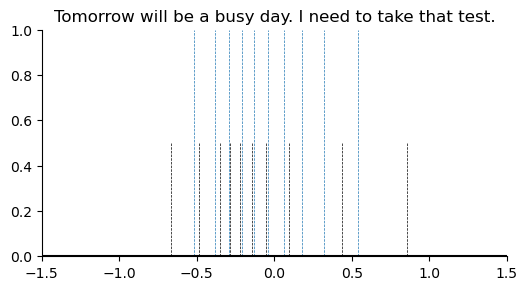

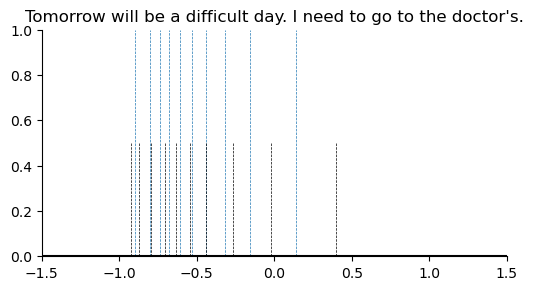

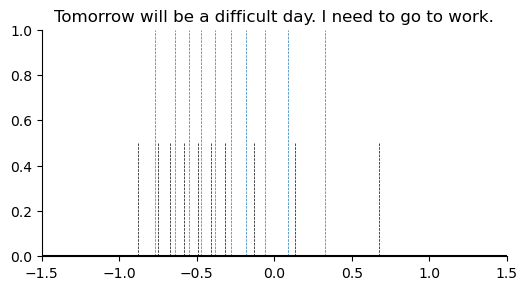

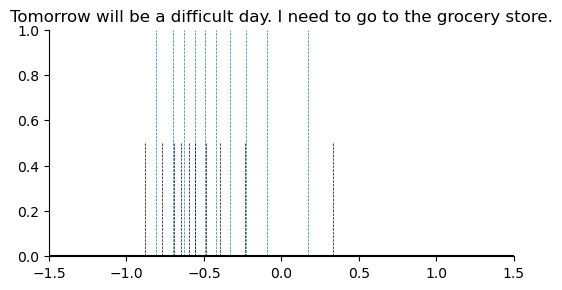

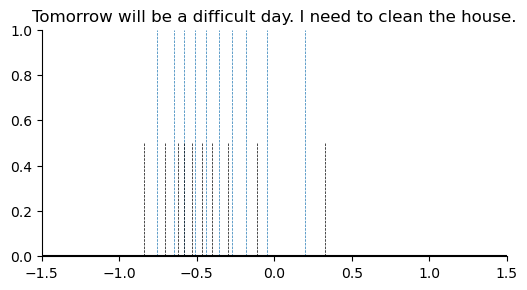

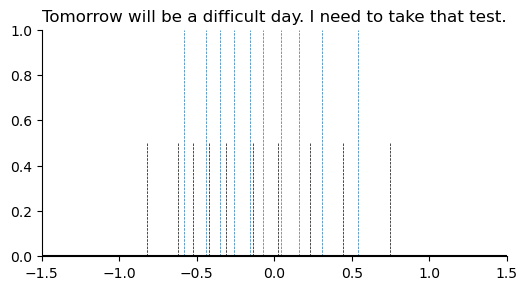

In [97]:
plot_examples(v5_stems, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

##### Random Examples

In [98]:
np.random.seed(1)
rand_examples = [s.split('p=')[0].strip() for s in np.random.choice(sentences, 10)]
rand_examples

['Tomorrow will be a difficult day. I need to go to the grocery store. I need to get my son some groceries. I need to get a car. I need to do this.',
 "Tomorrow will be an easy day. I need to go to work. I need to be there. I can't do it without you. I need to get up.",
 "Tomorrow will be a difficult day. I need to clean the house. I need to make sure everyone's OK. I need to help the people who are here. I need to make sure that we are all OK.",
 'Tomorrow will be an easy day. I need to clean the house. I need to get ready for work. I need to go for a walk. I need to take a shower.',
 "Tomorrow will be a difficult day. I need to go to the doctor's. I need to go to the hospital. I need to talk to them. I need to come home.",
 "Tomorrow will be a difficult day. I need to go to the grocery store. I need to get my medication. I need to be ready to go to school tomorrow morning. I need to be sure that I don't need to be in the hospital.",
 'Tomorrow will be an easy day. I will go on a bike

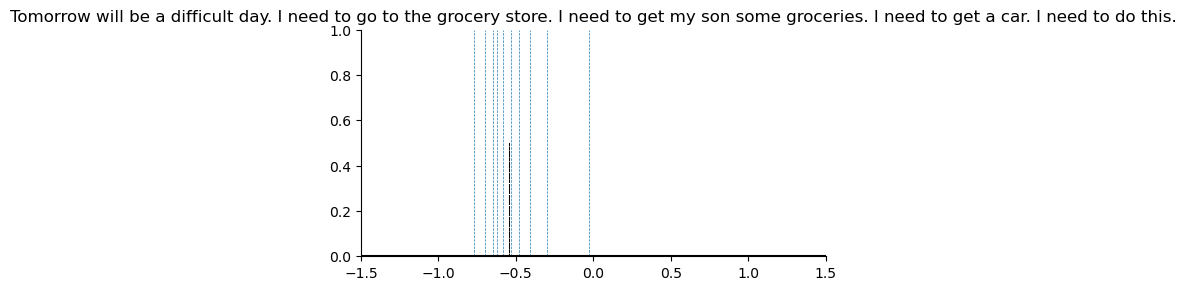

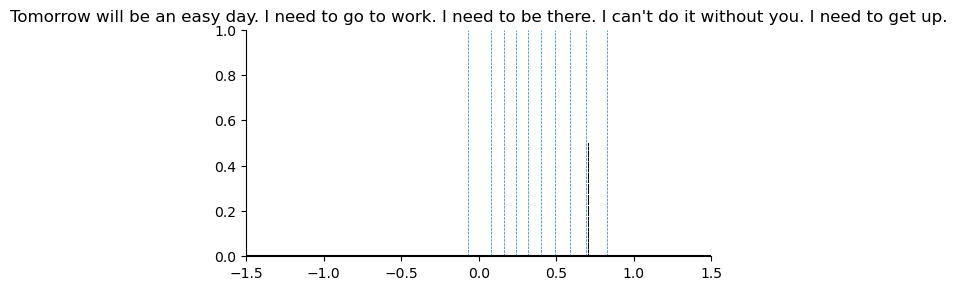

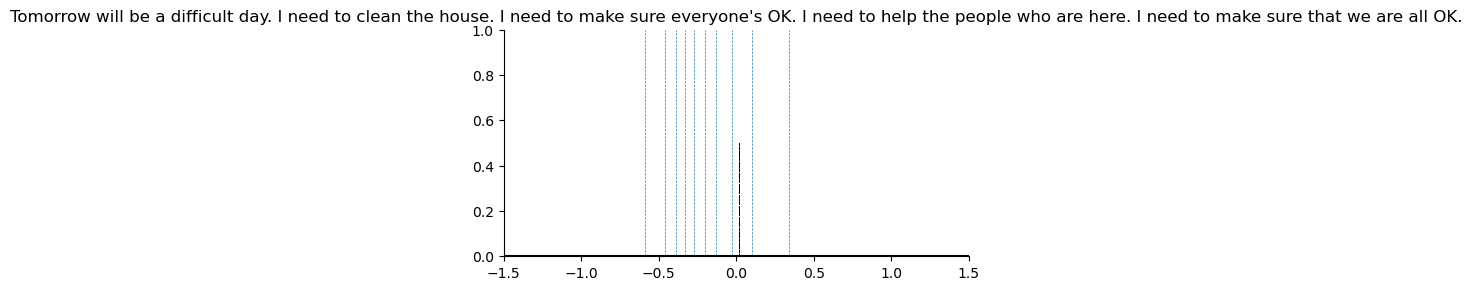

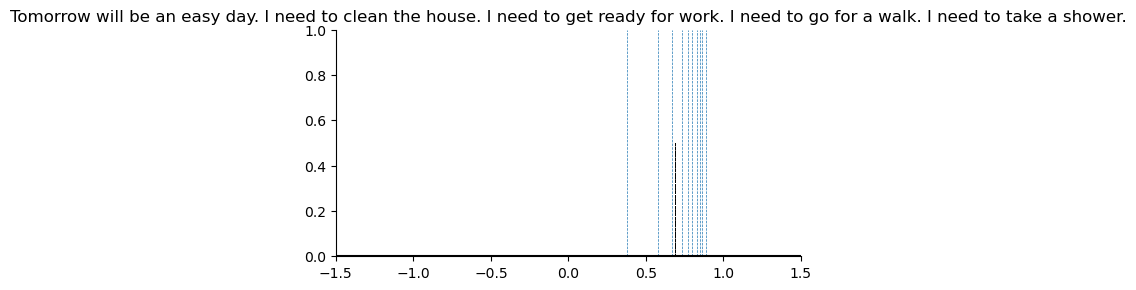

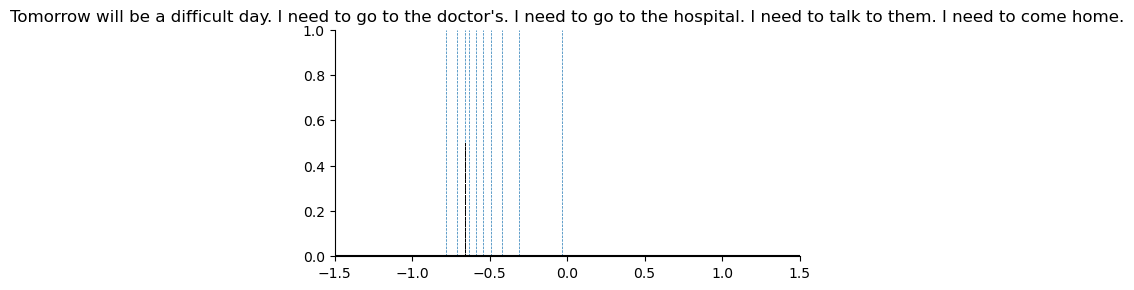

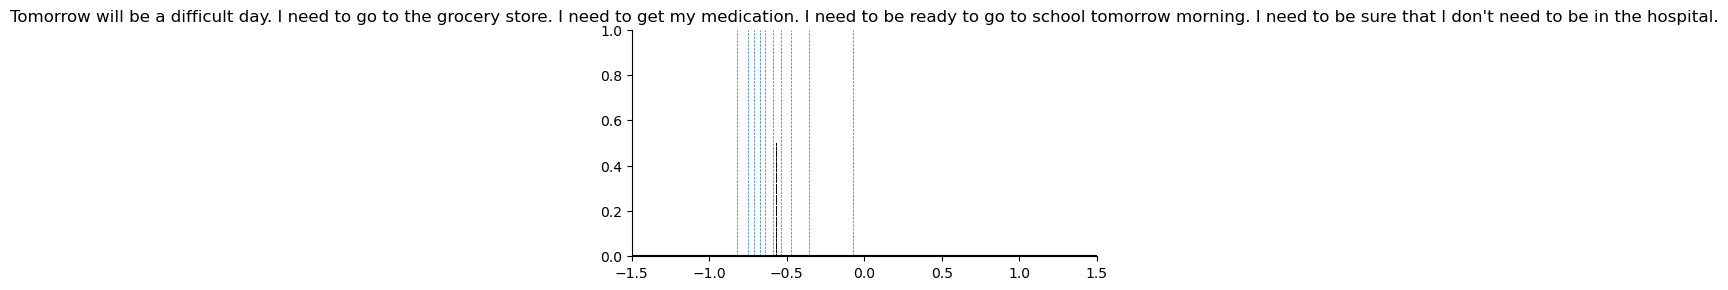

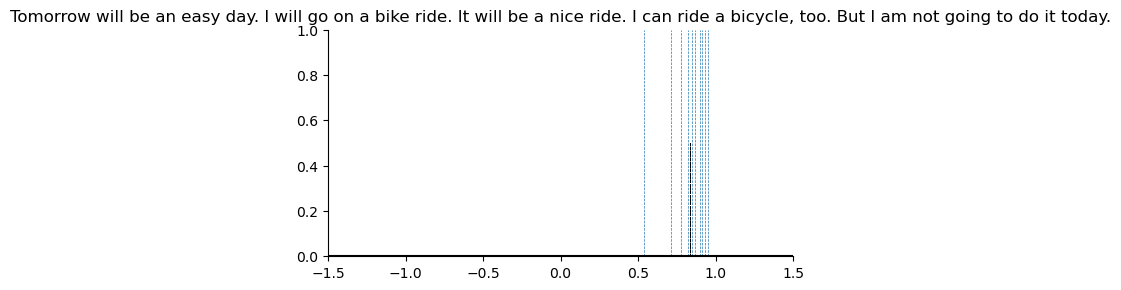

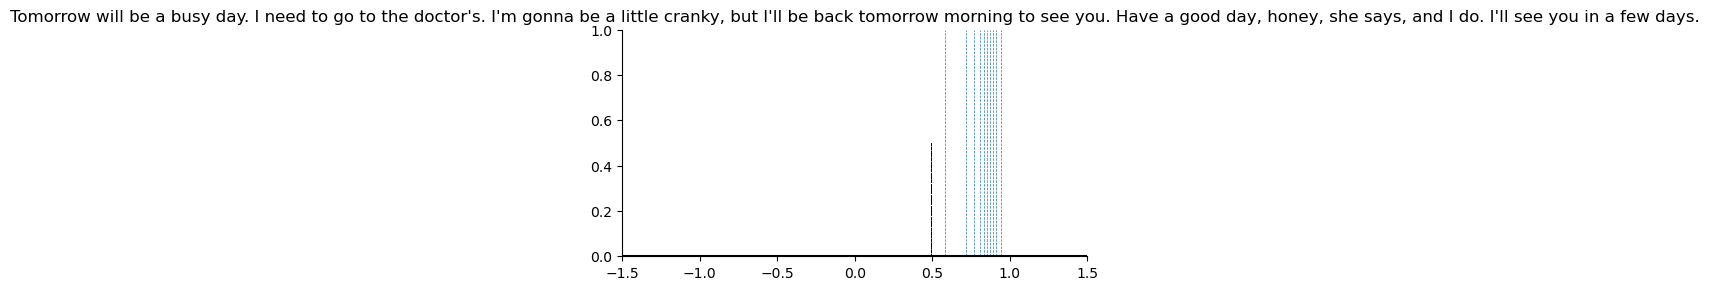

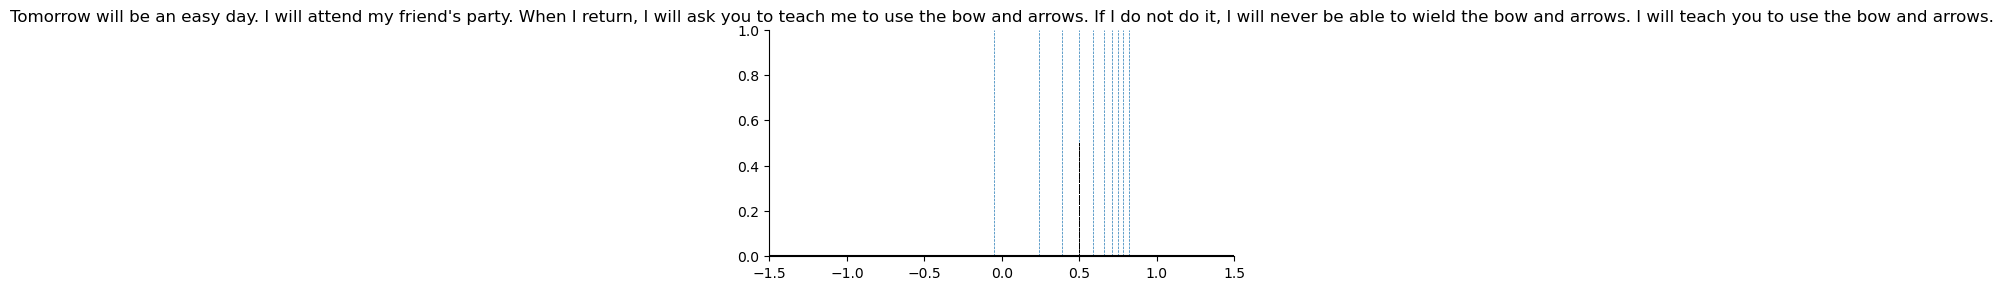

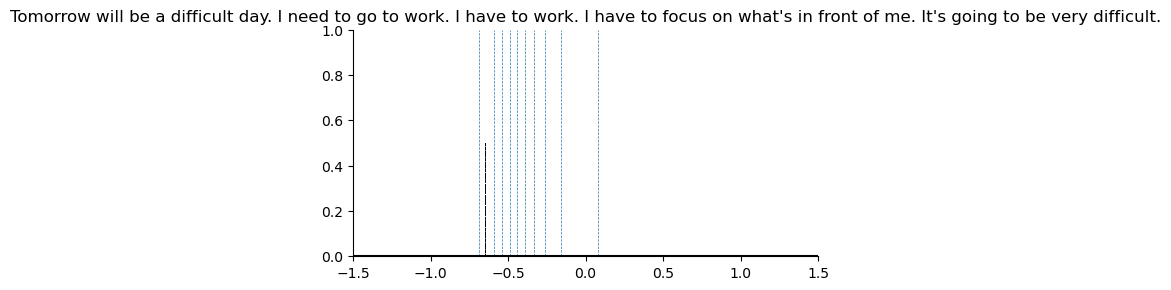

In [99]:
plot_examples(rand_examples, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

##### Manual Examples

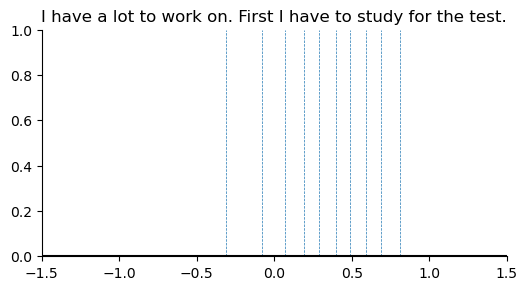

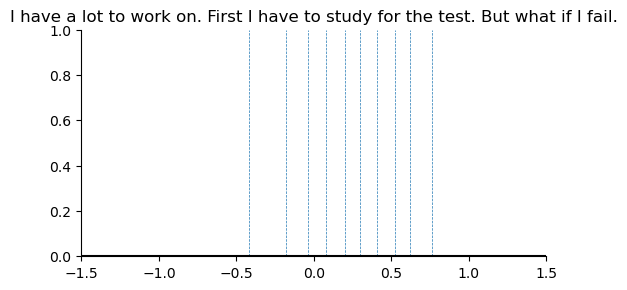

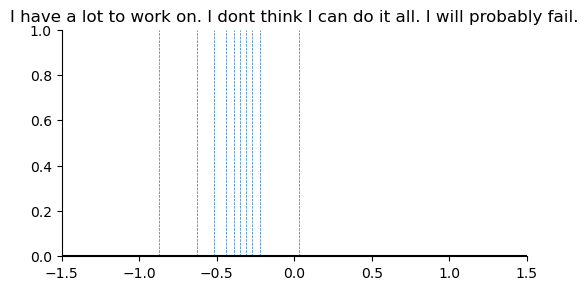

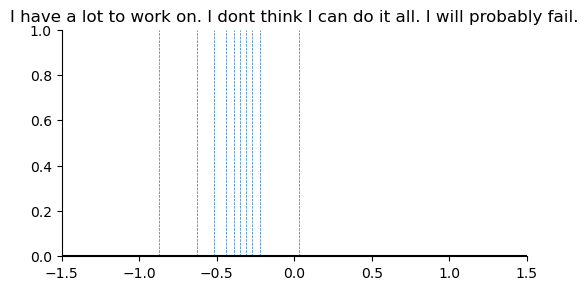

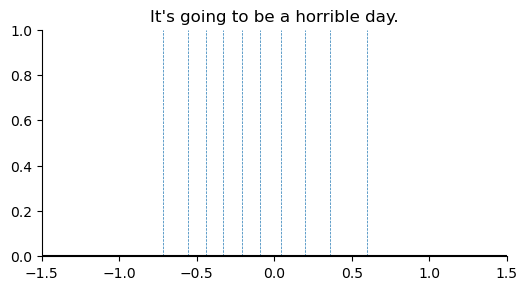

In [100]:
examples = ['I have a lot to work on. First I have to study for the test.',
            'I have a lot to work on. First I have to study for the test. But what if I fail.',
            'I have a lot to work on. I dont think I can do it all. I will probably fail.',
            'I have a lot to work on. I dont think I can do it all. I will probably fail.',
            "It's going to be a horrible day.",
           ]

plot_examples(examples, sentences, composite_rewards, tokenizer, model, 
              out['Z_network'], out['taus'])

### Generating Examples

In [51]:
def plot_dists(sentences_cvar, rewards, sentences):
    # full distribution
    stem = ""

    fig,axes = plt.subplots(len(alphas)+1, 1, figsize=(8,4*len(alphas)), dpi=200)

    plt.sca(axes[0])
    sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')
    plt.hist(rewards[sel], alpha=0.5, density=False)
    
    mean = np.nanmean(rewards[sel])
    plt.axvline(x=mean, color=sns.color_palette()[0])

    sns.despine(left=True)
    plt.xlim([-1.1,1.1])
    plt.title(f'alpha=1')
    plt.yticks([])

    # alphas 
    for a, alpha in enumerate(alphas[::-1]):

        plt.sca(axes[a+1]) 
        sel_cvar = np.array([s.startswith(stem) for s in sentences_cvar[alpha]]).astype('bool')
        plt.hist(rewards_cvar[alpha][sel_cvar], alpha=0.5, color=sns.color_palette()[0],density=False)

        mean = np.nanmean(rewards_cvar[alpha][sel_cvar])
        plt.axvline(x=mean, color=sns.color_palette()[0])
        
        plt.xlim([-1.1,1.1])
        plt.title(f'alpha={alpha}')
        plt.yticks([])
        sns.despine(left=True)

    plt.tight_layout()

#### 100 Hidden Units (20 Epochs) - slow learning rate -  this actually looks pretty good

In [29]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05,]
top_k =10
extra = '_steps3_100units_slow_lr'
for alpha in alphas:

    file = f'../data/results/sentence_chains_I_5/generations_alpha{alpha}{extra}.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    rewards_cvar[alpha] =  []
    for s in sentences_cvar[alpha]:
        r = np.sum(np.array(s.split('r_all=')[-1].split(',')).astype('float'))
        rewards_cvar[alpha].append(r)

    rewards_cvar[alpha]=np.array(rewards_cvar[alpha])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


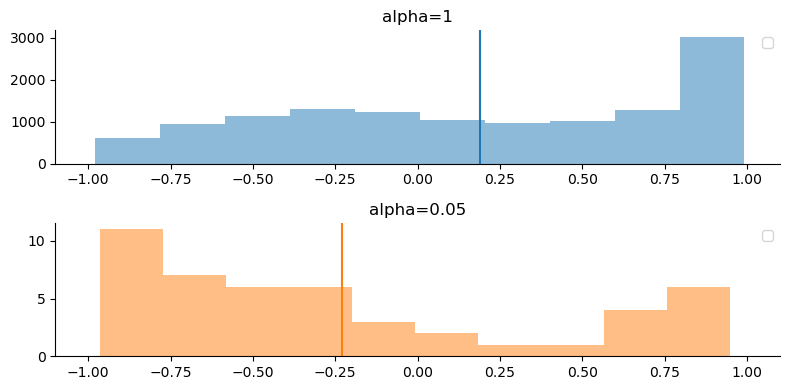

In [30]:
plot_dists(sentences_cvar, composite_rewards, sentences)

In [31]:
alpha =0.05
ss = sentences_cvar[alpha]
rs = rewards_cvar[alpha]

ss = [s for _,s in sorted(zip(rs,ss))]
rs = [r for _,r in sorted(zip(rs,rs))]
for s, (sentence,r) in enumerate(zip(ss,rs)):
    if sentence not in sentences:
        print(s, sentence)
        print()

0 Tomorrow will be a busy day. I need to go to the doctor's. I can't walk. I feel like my body is rejecting me. I feel like I'm on the verge of death. p=0.07,0.042,0.214 r=-0.855,-0.964,-0.948 r_all=-0.964

1 Tomorrow will be a difficult day. I might need to work late. I might not be able to get to work. I might be sick. I might be just not there. p=0.475,0.039,0.078 r=-0.896,-0.897,-0.578 r_all=-0.93

2 Tomorrow will be a difficult day. I might need to work late. I might have to go to a doctor's appointment. I might need to be in the office late. I might need to be at a job I don't want to be at. p=0.014,0.755,0.187 r=-0.314,-0.427,-0.848 r_all=-0.909

3 Tomorrow will be a difficult day. I need to go to the doctor's. I need to see a doctor. I don't know what to do. What am I going to do? I just don't know what to do. p=0.767,0.102,0.272 r=-0.731,-0.822,-0.828 r_all=-0.897

4 Tomorrow will be a difficult day. I need to go to work. I can't stay here any longer. I need to go. I won't be 

#### 10 Hidden Units (20 Epochs) - slow learning rates

In [32]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05,]
top_k =10
extra = '_steps3_10units_slow_lr'
for alpha in alphas:

    file = f'../data/results/sentence_chains_I_5/generations_alpha{alpha}{extra}.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    rewards_cvar[alpha] =  []
    for s in sentences_cvar[alpha]:
        r = np.sum(np.array(s.split('r_all=')[-1].split(',')).astype('float'))
        rewards_cvar[alpha].append(r)

    rewards_cvar[alpha]=np.array(rewards_cvar[alpha])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


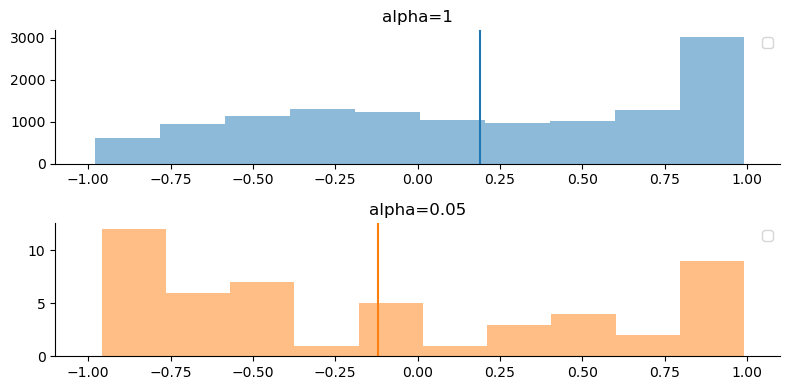

In [33]:
plot_dists(sentences_cvar, composite_rewards, sentences)

In [34]:
alpha =0.05
ss = sentences_cvar[alpha]
rs = rewards_cvar[alpha]

ss = [s for _,s in sorted(zip(rs,ss))]
rs = [r for _,r in sorted(zip(rs,rs))]
for s, (sentence,r) in enumerate(zip(ss,rs)):
    if sentence not in sentences:
        print(s, sentence)
        print()

0 Tomorrow will be a difficult day. I need to go to the doctor's. I am still having trouble with my stomach. I am not feeling well. I am in pain. p=0.056,0.71,0.047 r=-0.947,-0.945,-0.897 r_all=-0.959

1 Tomorrow will be a difficult day. I need to go to the doctor's. I don't know what's going to happen, but I have to go. I don't want to go to the hospital. They said I had a very bad infection. p=0.567,0.02,0.01 r=-0.137,-0.936,-0.949 r_all=-0.933

2 Tomorrow will be a difficult day. I need to go to work. I'm not feeling very well. I'm feeling a little bit ill. I have to go to work, but I don't feel good. p=0.183,0.535,0.645 r=-0.938,-0.859,-0.926 r_all=-0.926

3 Tomorrow will be a difficult day. I will go to the gym. I will not be able to get up. I will sit in bed and think about what happened today. I will cry. p=0.148,0.004,0.019 r=-0.924,-0.13,-0.088 r_all=-0.922

4 Tomorrow will be a difficult day. I need to go to the doctor's. I don't know what I will say. I'm not sure I'll be abl

#### 100 Hidden Units (48 Epochs) 

In [52]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05,]
top_k =10
extra = '_steps3_100units'
for alpha in alphas:

    file = f'../data/results/sentence_chains_I_5/generations_alpha{alpha}{extra}.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    rewards_cvar[alpha] =  []
    for s in sentences_cvar[alpha]:
        r = np.sum(np.array(s.split('r_all=')[-1].split(',')).astype('float'))
        rewards_cvar[alpha].append(r)

    rewards_cvar[alpha]=np.array(rewards_cvar[alpha])

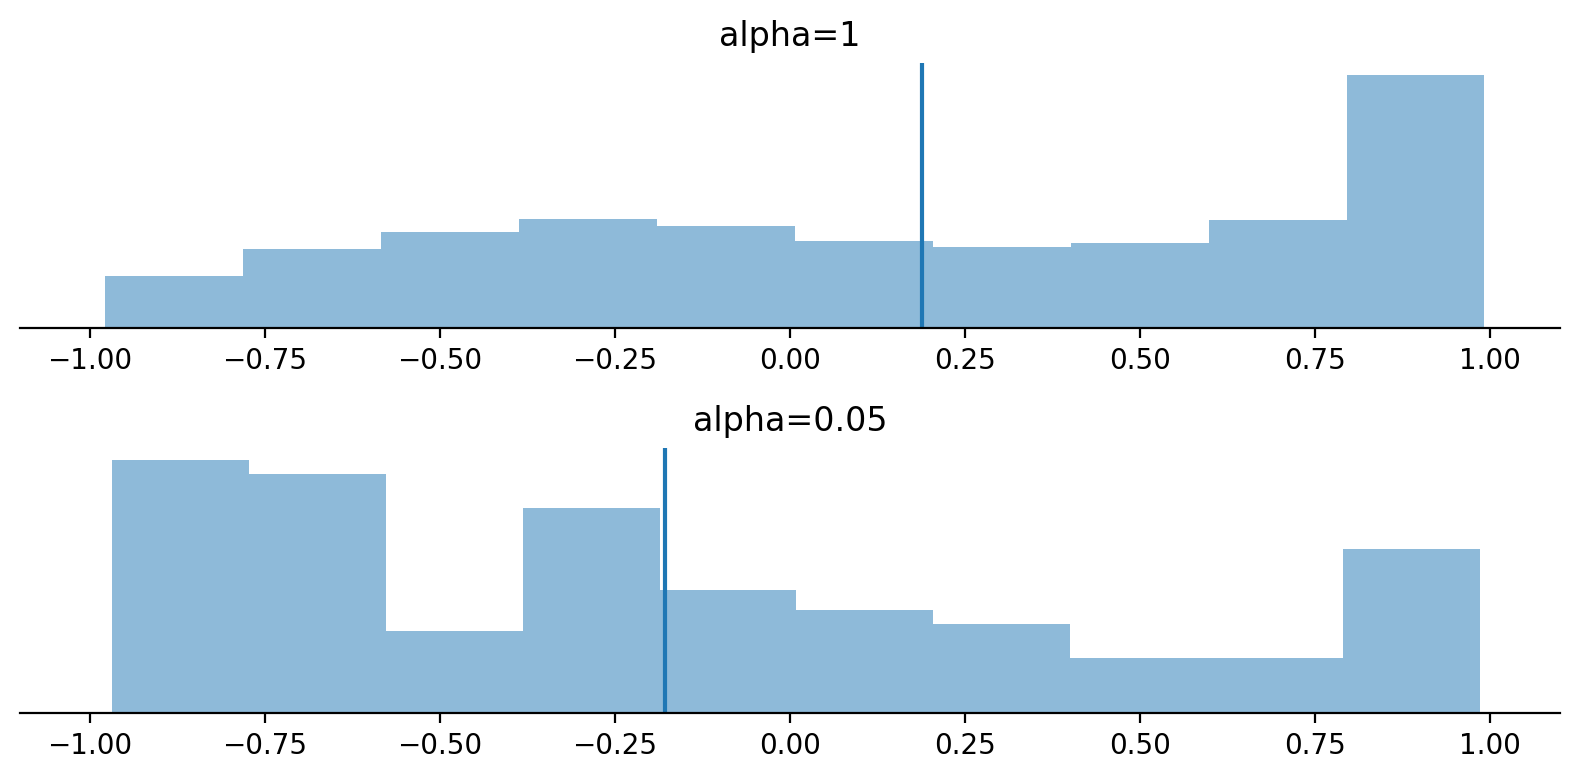

In [53]:
plot_dists(sentences_cvar, composite_rewards, sentences)

In [54]:
alpha =0.05
ss = sentences_cvar[alpha]
rs = rewards_cvar[alpha]

ss = [s for _,s in sorted(zip(rs,ss))]
rs = [r for _,r in sorted(zip(rs,rs))]
for s, (sentence,r) in enumerate(zip(ss,rs)):
    if sentence not in sentences:
        #print(s, sentence)
        #print()
        print(sentence.split('p=')[0]+'r='+str(r))

Tomorrow will be a difficult day. I need to go to the grocery store. This is very dangerous. I will probably get shot. I will not be able to explain it to you. r=-0.968
Tomorrow will be a difficult day. I need to go to the doctor's. I'm not sure how much longer I can do this. I'm tired. I'm tired of getting sick. r=-0.955
Tomorrow will be a difficult day. I might need to work late. I might be exhausted. I might be in a bad mood. I might have a cold or a sore throat. r=-0.94
Tomorrow will be a difficult day. I need to go to the doctor's. I am going to the hospital. There are going to be some problems. I can't walk properly. r=-0.939
Tomorrow will be a difficult day. I might need to work late. I can't imagine how this day will affect the rest of my life. I feel so confused. I'm not sure what to do. r=-0.938
Tomorrow will be a difficult day. I might need to work late. I might need to stop. I might have to give up my job. I might have to make a bad decision. r=-0.935
Tomorrow will be a dif

## What-ifs

### Loading Training Data 

In [27]:
file = '../data/results/sentence_chains_I_5/generations_seed5_whatif.txt'
f = open(file, "r")
sentences = f.readlines()
sentences = [s.replace('\n','') for s in sentences]
composite_rewards =[s.split('r_all=')[1] for s in sentences]
sentences_wo_rall = [s.split('r_all=')[0] for s in sentences]
state_rewards =  [np.array(s.split('r=')[-1].split(',')).astype('float') for s in sentences_wo_rall]


In [28]:
# removing some bad examples #
state_rewards2 = []
sentences2 = []
composite_rewards2 = []
for r,s,rc in zip(state_rewards, sentences, composite_rewards):
    if len(r)!=3:
        pass
    else:
        state_rewards2.append(r)
        sentences2.append(s)
        composite_rewards2.append(rc)
sentences = sentences2
state_rewards = np.array(state_rewards2)
composite_rewards = np.array(composite_rewards2).astype('float')

# choose rewards 
summed_rewards = state_rewards.sum(axis=1)
final_rewards = state_rewards[:,-1]


assert len(sentences) == len(final_rewards)

In [29]:
np.array(state_rewards)

array([[ 0.088, -0.29 , -0.586],
       [-0.343, -0.795,  0.006],
       [ 0.307,  0.096,  0.066],
       ...,
       [-0.574, -0.495, -0.258],
       [-0.019, -0.6  , -0.394],
       [-0.059, -0.735, -0.709]])

In [30]:
summed_rewards

array([-0.788, -1.132,  0.469, ..., -1.327, -1.013, -1.503])

In [31]:
final_rewards

array([-0.586,  0.006,  0.066, ..., -0.258, -0.394, -0.709])

In [32]:
composite_rewards

array([-0.519, -0.144,  0.077, ...,  0.052, -0.643, -0.837])

In [33]:
len(sentences)
len(final_rewards)

11603

### Plotting the distributions

Text(0.5, 1.0, 'composite reward')

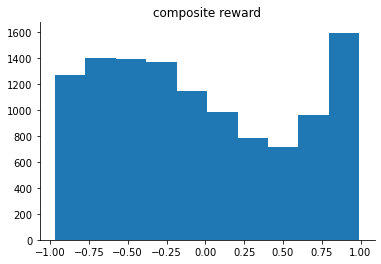

In [34]:
plt.hist(composite_rewards)
sns.despine()
plt.title('composite reward')

Text(0.5, 1.0, 'final reward')

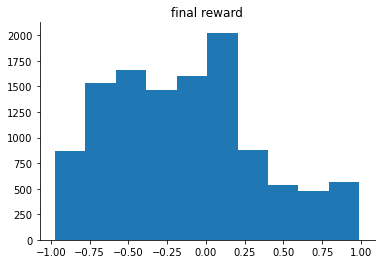

In [35]:
plt.hist(final_rewards)
sns.despine()
plt.title('final reward')

Text(0.5, 1.0, 'summed reward')

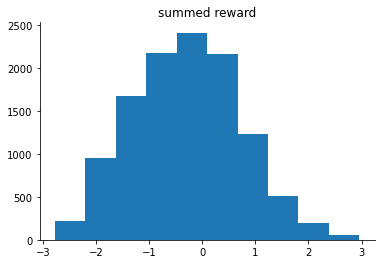

In [36]:
plt.hist(summed_rewards)
sns.despine()
plt.title('summed reward')

### Plotting the distributions (by stems)

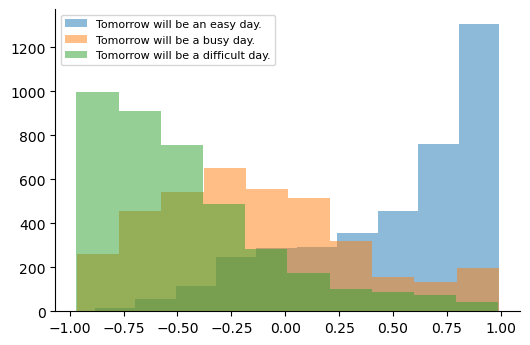

In [37]:
stems = ["Tomorrow will be an easy day.",
         "Tomorrow will be a busy day.",
         "Tomorrow will be a difficult day."]

plt.figure(dpi=100)
for stem in stems:
    sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')
    plt.hist(composite_rewards[sel], label=stem, alpha=0.5)
    plt.legend(fontsize=8)
sns.despine()

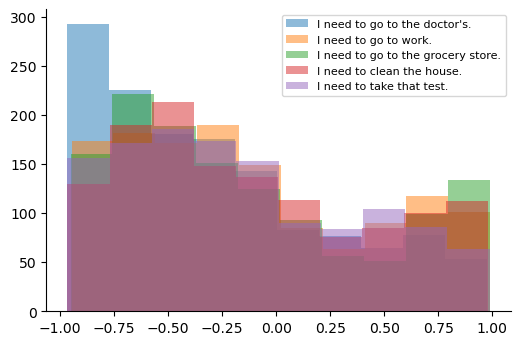

In [38]:
stems = ["I need to go to the doctor's.", 'I need to go to work.', 
         'I need to go to the grocery store.', 'I need to clean the house.',  'I need to take that test.',]

plt.figure(dpi=100)
for stem in stems:
    sel = np.array([True if stem in s else False for s in sentences ]).astype('bool')
    plt.hist(composite_rewards[sel], label=stem, alpha=0.5)
    plt.legend(fontsize=8)
sns.despine()

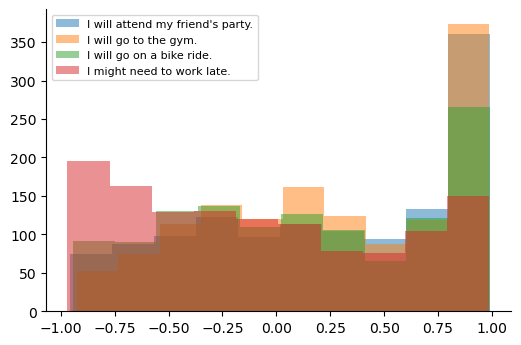

In [39]:
stems = ["I will attend my friend's party.", "I will go to the gym.", "I will go on a bike ride.", "I might need to work late." ]

plt.figure(dpi=100)
for stem in stems:
    sel = np.array([True if stem in s else False for s in sentences ]).astype('bool')
    plt.hist(composite_rewards[sel], label=stem, alpha=0.5)
    plt.legend(fontsize=8)
sns.despine()

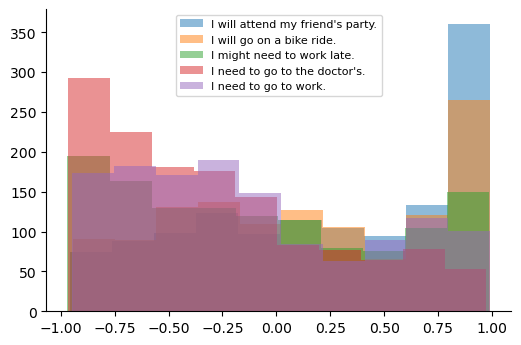

In [40]:
stems = ["I will attend my friend's party.", "I will go on a bike ride.", "I might need to work late.", "I need to go to the doctor's.", 'I need to go to work.',  ]

plt.figure(dpi=100)
for stem in stems:
    sel = np.array([True if stem in s else False for s in sentences ]).astype('bool')
    plt.hist(composite_rewards[sel], label=stem, alpha=0.5)
    plt.legend(fontsize=8)
sns.despine()

### Print some Negative Examples

#### Final rewards

In [41]:
sort_idx = np.argsort(final_rewards)
for s in np.array(sentences)[sort_idx][0:20]:
    print(s)
    print()

Tomorrow will be a difficult day. I will attend my friend's party. I will go and see my friend. What if I have to leave before I can come back? I will be a complete failure, and you will never see me again. p=0.117,0.074,0.07 r=0.568,-0.434,-0.974 r_all=-0.813

Tomorrow will be an easy day. I need to go to the doctor's. He's coming tomorrow and we will see about getting some rest. It's nothing serious. I've been having a headache and it's not much better. p=0.072,0.086,0.072 r=0.092,-0.116,-0.972 r_all=-0.239

Tomorrow will be an easy day. I might need to work late. What if I'm late again? I can't do this. I'm so late, I'm like a fucking robot. p=0.075,0.078,0.079 r=-0.623,-0.932,-0.971 r_all=-0.74

Tomorrow will be a difficult day. I need to take that test. I'm going to pass it. What if I fail it? I'll lose my life, I'm so embarrassed. p=0.083,0.071,0.078 r=0.37,-0.656,-0.968 r_all=-0.699

Tomorrow will be a busy day. I need to take that test. I need to finish my study. Then I can lea

#### Summed Rewards

In [42]:
sort_idx = np.argsort(summed_rewards)
for s in np.array(sentences)[sort_idx][0:20]:
    print(s)
    print()

Tomorrow will be a busy day. I need to go to the doctor's. I don't know what's going on with me. Then I'll go back to my old life, and it won't be very good. It's all wrong. p=0.082,0.08,0.067 r=-0.906,-0.92,-0.949 r_all=-0.966

Tomorrow will be a busy day. I need to go to the doctor's. I'm a bit worried I'm going to have a heart attack. Then I'll be in this hellhole forever. I'll never get back to normal again. p=0.067,0.072,0.067 r=-0.912,-0.949,-0.913 r_all=-0.958

Tomorrow will be a difficult day. I need to go to the doctor's. I have a head injury. My head is in a mess. The concussion is bothering me. p=0.076,0.096,0.089 r=-0.929,-0.925,-0.918 r_all=-0.954

Tomorrow will be a difficult day. I need to go to the doctor's. What if I have a heart attack tomorrow and get killed? My family will be devastated, my children will be devastated. Then I will not have a family, so I will have no reason to live. p=0.07,0.085,0.073 r=-0.923,-0.949,-0.887 r_all=-0.963

Tomorrow will be a difficult

#### Composite Rewards

In [43]:
sort_idx = np.argsort(composite_rewards)
for s in np.array(sentences)[sort_idx][0:20]:
    print(s)
    print()

Tomorrow will be a difficult day. I might need to work late. What if I have to go to the toilet? I can't stand this anymore. I want to tell them. p=0.068,0.086,0.079 r=-0.648,-0.966,0.096 r_all=-0.969

Tomorrow will be a difficult day. I need to take that test. What if they tell me I'm not a human? What if I can't go to school tomorrow? What if my family will come and threaten to kill me? p=0.07,0.083,0.101 r=-0.651,-0.744,-0.933 r_all=-0.966

Tomorrow will be a difficult day. I need to go to the doctor's. What if my daughter's cancer has spread to my brain? What if I can't see her again? What if she dies in the womb? p=0.068,0.068,0.066 r=-0.911,-0.68,-0.591 r_all=-0.966

Tomorrow will be a busy day. I need to go to the doctor's. I don't know what's going on with me. Then I'll go back to my old life, and it won't be very good. It's all wrong. p=0.082,0.08,0.067 r=-0.906,-0.92,-0.949 r_all=-0.966

Tomorrow will be a difficult day. I need to clean the house. Then I will go to the doctor

### Print some Positive Examples

#### Final rewards

In [116]:
sort_idx = np.argsort(final_rewards)
for s in np.array(sentences)[sort_idx][-20:]:
    print(s)
    print()

Tomorrow will be an easy day. I might need to work late. I will take a nap and then go back to work. It is all very peaceful. We are all happy and relaxed. p=0.078,0.097,0.073 r=0.035,0.918,0.953 r_all=0.963

Tomorrow will be a busy day. I need to go to the doctor's. I hope that I can work out this evening and then go home. Then I'll see you tomorrow morning. I love you. p=0.085,0.083,0.083 r=0.743,0.16,0.958 r_all=0.896

Tomorrow will be an easy day. I might need to work late. I can't wait to see you. Good bye, Lisa. I love you. p=0.075,0.113,0.082 r=0.984,-0.135,0.958 r_all=0.988

Tomorrow will be an easy day. I need to go to work. I will be there for you. I will come back as soon as possible. I love you. p=0.087,0.085,0.072 r=0.617,0.602,0.958 r_all=0.98

Tomorrow will be a difficult day. I will go to the gym. I will stay at home with the kids. I will not do any work. Then, my family will take me in their arms and we will be happy. p=0.076,0.073,0.086 r=0.046,-0.782,0.964 r_all=0.79

#### Summed Rewards

In [117]:
sort_idx = np.argsort(summed_rewards)
for s in np.array(sentences)[sort_idx][-20:]:
    print(s)
    print()

Tomorrow will be an easy day. I might need to work late. I will take a nap and then go back to work. It is all very peaceful. We are all happy and relaxed. p=0.078,0.097,0.073 r=0.035,0.918,0.953 r_all=0.963

Tomorrow will be a busy day. I might need to work late. Then we'll see. I'm sure they'll all be looking forward to it. Thanks for the invite! It means a lot to me. p=0.082,0.084,0.072 r=0.056,0.917,0.987 r_all=0.978

Tomorrow will be a difficult day. I will attend my friend's party. I hope you will be able to come. You may have been with me during the morning. We had a great time. p=0.097,0.086,0.092 r=0.884,0.115,0.972 r_all=0.91

Tomorrow will be a busy day. I need to go to the grocery store. Come on. Let's go! The girl looked at him and smiled. He was so happy to see her. p=0.082,0.072,0.086 r=0.124,0.889,0.977 r_all=0.957

Tomorrow will be a difficult day. I need to go to work. I need to be productive and think, but also go home and be with my family. Then I will be fine. I am

#### Composite Rewards

In [118]:
sort_idx = np.argsort(composite_rewards)
for s in np.array(sentences)[sort_idx][-20:]:
    print(s)
    print()

Tomorrow will be an easy day. I might need to work late. I will take a nap and then go back to work. It is all very peaceful. We are all happy and relaxed. p=0.078,0.097,0.073 r=0.035,0.918,0.953 r_all=0.963

Tomorrow will be an easy day. I will go to the gym. Then, I will eat some food and then I will sleep. But I am not going to miss it at all. I want to do it. p=0.073,0.083,0.084 r=0.157,0.531,0.798 r_all=0.963

Tomorrow will be a busy day. I will attend my friend's party. We will be having the biggest meal ever. Then I will meet with my friend and have a good talk. We will also be doing some shopping. p=0.071,0.078,0.076 r=0.977,0.88,0.208 r_all=0.963

Tomorrow will be a busy day. I will attend my friend's party. And then I will go to see the great, awesome and possibly impossible thing. I'll try not to put it off so much. On a recent trip to Washington, D. p=0.074,0.075,0.083 r=0.936,-0.167,0.024 r_all=0.963

Tomorrow will be an easy day. I will go to the gym. What if the weather 